# Imports

In [1]:
# for the data
import pandas as pd
import numpy as np
import requests
import re
# for plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Get the data

In [2]:
# urls to the API
urlMales = 'https://games.crossfit.com/competitions/api/v1/competitions/games/2019/leaderboards?division=1&sort=0&page=1'
urlFemales = 'https://games.crossfit.com/competitions/api/v1/competitions/games/2019/leaderboards?division=2&sort=0&page=1'
#Sends the request and reads the response.
responseMales = requests.get(urlMales)
responseFemales = requests.get(urlFemales)
#Loads response as JSON
responseMales = responseMales.json()
responseFemales = responseFemales.json()

In [3]:
# how many competitors, used for for loops
totalMaleCompetitors = responseMales['pagination']['totalCompetitors'] - 1 # index starts at 0 in Python
totalFemaleCompetitors = responseFemales['pagination']['totalCompetitors'] - 1 # index starts at 0 in Python
# how many events, used for for loops
totalEvents = len(responseMales['ordinals'])

In [52]:
# select a competitor to see what data we have
leaderboardRows = responseMales['leaderboardRows']
responseMales['leaderboardRows'][20].keys()

dict_keys(['overallScore', 'overallRank', 'ui', 'entrant', 'scores', 'cf_rank_order'])

In [5]:
eventData = responseFemales['leaderboardRows'][2]['scores']
# each event contains the following data, this is event 5
eventData[4]

{'ordinal': 5,
 'breakdown': '92 pts',
 'lane': 6,
 'scoreIdentifier': '0000',
 'exists': True,
 'workoutresult': '--',
 'mobileScoreDisplay': '664 rep, 92 pts',
 'rank': '3',
 'heat': 2,
 'points': '92',
 'scoreDisplay': '664 rep',
 'location': '',
 'time': '664',
 'judge': '',
 'workoutrank': '3'}

## Getting male and female competitor information into a dataframe

### Male competitors

In [366]:
# create a dataframe that contains one line for every male competitor
df_cfgMales = pd.DataFrame(np.zeros((totalMaleCompetitors,11)),columns=['competitorId','competitorName','overallRank', 'overallScore',
                                                                       'height', 'heightInInches', 'weight', 'weightInKg',
                                                                        'age',
                                                                       'countryOfOriginName','affiliateName'])
# just filling the dataframe with nan data
df_cfgMales = df_cfgMales.replace(0,np.nan)

# loop over all events for all competitors
for i in range(0,totalMaleCompetitors,1):
    competitorData = responseMales['leaderboardRows'][i]
        
    # competition data
    df_cfgMales.loc[i,'overallRank'] = competitorData['overallRank']
    # some athletes got a DF score due to withdrawing from competiton before first event
    if len(competitorData['overallScore']) < 1:
        df_cfgMales.loc[i,'overallScore'] = "0"
    else:
        df_cfgMales.loc[i,'overallScore'] = competitorData['overallScore']      
    # get some personal data!
    df_cfgMales.loc[i,'competitorId'] = str(competitorData['entrant']['competitorId'])
    df_cfgMales.loc[i,'competitorName'] = competitorData['entrant']['competitorName']
    df_cfgMales.loc[i,'countryOfOriginName'] = competitorData['entrant']['countryOfOriginName']
    df_cfgMales.loc[i,'height'] = competitorData['entrant']['height']
    
    # converting the height string to total inches so I can calculate height in cm later
    heightInFeet = int(competitorData['entrant']['height'][:1])
    # to account for if the inches are 10 or over
    if len(competitorData['entrant']['height']) > 4:
        heightInInches = int(competitorData['entrant']['height'][2:4])
    else:
        heightInInches = int(competitorData['entrant']['height'][2:3])
    df_cfgMales.loc[i,'heightInInches'] = heightInFeet*12 + heightInInches
    
    df_cfgMales.loc[i,'age'] = competitorData['entrant']['age']
    # clean lbs from weight
    df_cfgMales.loc[i,'weight'] = re.sub("lbs", "", competitorData['entrant']['weight'])
    try:
        df_cfgMales.loc[i,'affiliateName'] = competitorData['entrant']['affiliateName']
    except:
        df_cfgMales.loc[i,'affiliateName'] = 'Unaffiliated'
    # clean the "T" from workoutRank, this is when athletes are tied in a workout
    try:
        df_cfgMales.loc[i,'overallRank'] = re.sub("\D", "", df_cfgMales.loc[i,'overallRank'])
    except:
        df_cfgMales.loc[i,'overallRank'] = df_cfgMales['overallRank']
    df_cfgMales.loc[i,'overallRank'] = int(df_cfgMales.loc[i,'overallRank'])
# change overallRank and overallScore to a numeric value so we can to some calculations
df_cfgMales['overallRank'] = df_cfgMales['overallRank'].astype('int')
df_cfgMales['overallScore'] = df_cfgMales['overallScore'].astype('int')
df_cfgMales['age'] = df_cfgMales['age'].astype('int')
df_cfgMales['weight'] = df_cfgMales['weight'].astype('int')
# create a new columns and convert height to cm and wieght to kg
df_cfgMales['heightInCm'] = round(df_cfgMales['heightInInches'].apply(lambda x: x*2.54),1)
df_cfgMales['weightInKg'] = round(df_cfgMales['weight'].apply(lambda x: x/2.205),1)

#### Testing the results

In [367]:
df_cfgMales.head()

,competitorId,competitorName,overallRank,overallScore,height,heightInInches,weight,weightInKg,age,countryOfOriginName,affiliateName,heightInCm
0,153604,Mathew Fraser,1,984,"5'7""",67.0,195,88.4,29,United States,CrossFit Mayhem,170.2
1,2725,Noah Ohlsen,2,949,"5'7""",67.0,190,86.2,28,United States,Peak 360 CrossFit,170.2
2,81616,Björgvin Karl Guðmundsson,3,888,"5'10""",70.0,185,83.9,26,Iceland,CrossFit Hengill,177.8
3,34796,Scott Panchik,4,795,"5'9""",69.0,187,84.8,31,United States,CrossFit Mentality,175.3
4,16080,James Newbury,5,728,"5'10""",70.0,192,87.1,28,Australia,CrossFit Mode,177.8


In [8]:
df_cfgMales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 6 columns):
competitorId           143 non-null object
competitorName         143 non-null object
overallRank            143 non-null int32
overallScore           143 non-null int32
countryOfOriginName    143 non-null object
affiliateName          143 non-null object
dtypes: int32(2), object(4)
memory usage: 5.7+ KB


### Female competitors

In [369]:
# create a dataframe that contains one line for every competitor
df_cfgFemales = pd.DataFrame(np.zeros((totalFemaleCompetitors,11)),columns=['competitorId','competitorName','overallRank', 'overallScore',
                                                                       'height', 'heightInInches', 'weight', 'weightInKg',
                                                                        'age',
                                                                       'countryOfOriginName','affiliateName'])
df_cfgFemales = df_cfgFemales.replace(0,np.nan)

for i in range(0,totalFemaleCompetitors,1):
    competitorData = responseFemales['leaderboardRows'][i]        
    # competition data
    df_cfgFemales.loc[i,'overallRank'] = competitorData['overallRank']    
    # some athletes got a DF score due to withdrawing from competiton before first event
    if len(competitorData['overallScore']) < 1:
        df_cfgFemales.loc[i,'overallScore'] = "0"
    else:
        df_cfgFemales.loc[i,'overallScore'] = competitorData['overallScore'] 
    # get some personal data!
    df_cfgFemales.loc[i,'competitorId'] = str(competitorData['entrant']['competitorId'])
    df_cfgFemales.loc[i,'competitorName'] = competitorData['entrant']['competitorName']
    df_cfgFemales.loc[i,'countryOfOriginName'] = competitorData['entrant']['countryOfOriginName']
    df_cfgFemales.loc[i,'height'] = competitorData['entrant']['height']

    # converting the height string to total inches so I can calculate height in cm later
    heightInFeet = int(competitorData['entrant']['height'][:1])
    # to account for if the inches are 10 or over
    if len(competitorData['entrant']['height']) > 4:
        heightInInches = int(competitorData['entrant']['height'][2:4])
    else:
        heightInInches = int(competitorData['entrant']['height'][2:3])
    df_cfgFemales.loc[i,'heightInInches'] = heightInFeet*12 + heightInInches
    
    df_cfgFemales.loc[i,'age'] = competitorData['entrant']['age']
    # clean lbs from weight
    df_cfgFemales.loc[i,'weight'] = re.sub("lbs", "", competitorData['entrant']['weight'])
    try:
        df_cfgFemales.loc[i,'affiliateName'] = competitorData['entrant']['affiliateName']
    except:
        df_cfgFemales.loc[i,'affiliateName'] = 'Unaffiliated'
    # clean the "T" from workoutRank, this is when athletes are tied in a workout
    try:
        df_cfgFemales.loc[i,'overallRank'] = re.sub("\D", "", df_cfgFemales.loc[i,'overallRank'])
    except:
        df_cfgFemales[i,'overallRank'] = df_cfgFemales['overallRank']
    df_cfgFemales.loc[i,'overallRank'] = int(df_cfgFemales.loc[i,'overallRank'])
# change overallRank and overallScore to a numeric value so we can to some calculations
df_cfgFemales['overallRank'] = df_cfgFemales['overallRank'].astype('int')
df_cfgFemales['overallScore'] = df_cfgFemales['overallScore'].astype('int')
df_cfgFemales['age'] = df_cfgFemales['age'].astype('int')
df_cfgFemales['weight'] = df_cfgFemales['weight'].astype('int')
# create a new colmun and convert height to cm
df_cfgFemales['heightInCm'] = round(df_cfgFemales['heightInInches'].apply(lambda x: x*2.54),1)
df_cfgFemales['weightInKg'] = round(df_cfgFemales['weight'].apply(lambda x: x/2.205),1)

In [370]:
df_cfgFemales.head()

,competitorId,competitorName,overallRank,overallScore,height,heightInInches,weight,weightInKg,age,countryOfOriginName,affiliateName,heightInCm
0,163097,Tia-Clair Toomey,1,1071,"5'4""",64.0,128,58.0,25,Australia,CrossFit Mayhem,162.6
1,120480,Kristin Holte,2,876,"5'4""",64.0,130,59.0,33,Norway,CrossFit Oslo,162.6
2,264512,Jamie Greene,3,851,"5'4""",64.0,135,61.2,28,New Zealand,CrossFit Yas,162.6
3,55121,Katrin Tanja Davidsdottir,4,784,"5'7""",67.0,150,68.0,26,Iceland,CrossFit New England,170.2
4,305891,Karissa Pearce,5,714,"5'3""",63.0,139,63.0,30,United States,CrossFit Spot,160.0


In [233]:
df_cfgFemales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 11 columns):
competitorId           130 non-null object
competitorName         130 non-null object
overallRank            130 non-null int32
overallScore           130 non-null int32
height                 130 non-null object
heightInInches         130 non-null float64
weight                 130 non-null int32
age                    130 non-null int32
countryOfOriginName    130 non-null object
affiliateName          130 non-null object
heightInCm             130 non-null float64
dtypes: float64(2), int32(4), object(5)
memory usage: 9.3+ KB


## Getting male and female event information into a dataframe

### Start with finding the number of lines needed by using how the cuts were made

In [452]:
event1 = totalMaleCompetitors
event2 = 75 + 1 # there were for some reason 76 guy's that did event 2
event3 = 50
event4 = 40
event5 = 30
event6 = 20
event7To12 = 10*6
numberOfLinesMales = event1 + event2 + event3 + event4 + event5 + event6 + event7To12
numberOfLinesMales

419

In [13]:
# cutting structure to get the number of lines I need for the event results dataframe
event1 = totalFemaleCompetitors
event2 = 75
event3 = 50
event4 = 40
event5 = 30
event6 = 20
event7To12 = 10*5
numberOfLinesFemales = event1 + event2 + event3 + event4 + event5 + event6 + event7To12
numberOfLinesFemales

395

### Male event information

In [453]:
# create a dataframe that contains one line for every event for every competitor
df_cfgMalesEvents = pd.DataFrame(np.zeros((numberOfLinesMales,8)),columns=['competitorId','event','breakdown','lane',
                                                         'heat', 'points', 'time/score', 'workoutRank'])
# just filling the dataframe with nan data
df_cfgMalesEvents = df_cfgMalesEvents.replace(0,np.nan)

# loop over competitors
for i in range(0,totalMaleCompetitors,1):
    competitorData = responseMales['leaderboardRows'][i]
    # loop over all events for athlete i
    for j in range(0,totalEvents):
        # having it so that if an athlete has been cut or withdraws we do not write more event data for him
        # the loop breaks and goes up into the start again and starts with athlete i
        if (competitorData['scores'][j]['workoutrank'] == 'CUT' or
            competitorData['scores'][j]['workoutrank'] == 'WD'):
            break
        # j+(i*totalEvents) so for athlete 0 we get lines 0 - 11, for athlete 10 we get lines (120 - 131) etc.
        # get the competitorId so we can join later to the df_cfgMales dateframe
        df_cfgMalesEvents.loc[j+(i*totalEvents),'competitorId'] = str(competitorData['entrant']['competitorId'])
        # event results
        df_cfgMalesEvents.loc[j+(i*totalEvents),'event'] = competitorData['scores'][j]['ordinal']
        df_cfgMalesEvents.loc[j+(i*totalEvents),'breakdown'] = competitorData['scores'][j]['breakdown']
        df_cfgMalesEvents.loc[j+(i*totalEvents),'lane'] = competitorData['scores'][j]['lane']
        df_cfgMalesEvents.loc[j+(i*totalEvents),'heat'] = competitorData['scores'][j]['heat']
        df_cfgMalesEvents.loc[j+(i*totalEvents),'points'] = competitorData['scores'][j]['points']
        df_cfgMalesEvents.loc[j+(i*totalEvents),'time/score'] = competitorData['scores'][j]['time']
        df_cfgMalesEvents.loc[j+(i*totalEvents),'workoutRank'] = competitorData['scores'][j]['workoutrank']
        # clean the "T" from workoutRank, this is when athletes are tied in a workout
        try:
            df_cfgMalesEvents.loc[j+(i*totalEvents),'workoutRank'] = re.sub("\D", "", 
                                                                            df_cfgMalesEvents.loc[j+(i*totalEvents),'workoutRank'])
        except:
            df_cfgMalesEvents.loc[j+(i*totalEvents),'workoutRank'] = df_cfgMalesEvents.loc[j+(i*totalEvents),'workoutRank']

# drop the NaN rows that came because of the break statement if an athlete is cut
df_cfgMalesEvents = df_cfgMalesEvents.dropna()
# and then reset the index since it is all out of sync after that
df_cfgMalesEvents = df_cfgMalesEvents.reset_index()
# just naming the index column to oldIndex
df_cfgMalesEvents.columns = ['oldIndex'
                             ,'competitorId','event','breakdown','lane',
                                                         'heat', 'points', 'time/score', 'workoutRank']
# change non-numeric columns to numeric so we can to some calculations on them
df_cfgMalesEvents['points'] = df_cfgMalesEvents['points'].astype('int')
df_cfgMalesEvents['event'] = df_cfgMalesEvents['event'].astype('int')
df_cfgMalesEvents['workoutRank'] = df_cfgMalesEvents['workoutRank'].astype('int')

#### Testing the results

In [454]:
df_cfgMalesEvents.head()

,oldIndex,competitorId,event,breakdown,lane,heat,points,time/score,workoutRank
0,0,153604,1,100 pts,26.0,3.0,100,15:07.70,1
1,1,153604,2,100 pts,20.0,2.0,100,5:37.02,1
2,2,153604,3,68 pts,25.0,1.0,68,25:50.09,17
3,3,153604,4,40 pts,10.0,2.0,40,1:50.08,21
4,4,153604,5,96 pts,8.0,2.0,96,675,2


In [455]:
df_cfgMalesEvents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
oldIndex        418 non-null int64
competitorId    418 non-null object
event           418 non-null int32
breakdown       418 non-null object
lane            418 non-null float64
heat            418 non-null float64
points          418 non-null int32
time/score      418 non-null object
workoutRank     418 non-null int32
dtypes: float64(2), int32(3), int64(1), object(3)
memory usage: 24.6+ KB


In [456]:
df_cfgMalesEvents.describe()

,oldIndex,event,lane,heat,points,workoutRank
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,454.923445,3.454545,18.122010,1.514354,33.909091,38.638756
std,440.897323,2.941327,13.724488,0.679282,40.599422,36.765784
min,0.000000,1.000000,0.000000,0.000000,-63.000000,1.000000
25%,104.250000,1.000000,6.000000,1.000000,10.000000,9.000000
50%,303.500000,2.000000,14.500000,1.000000,35.000000,26.000000
75%,672.750000,5.000000,28.750000,2.000000,66.000000,57.000000
max,1692.000000,12.000000,50.000000,3.000000,100.000000,138.000000


In [47]:
# summing competitor points to check if it matches with df_cfgMales
totalPoints = df_cfgMalesEvents[['competitorId','points']].groupby('competitorId').sum()
totalPoints = totalPoints.sort_values(by=['points'],ascending=False)
df_totalPointsCheck = pd.merge(totalPoints, df_cfgMales, how="inner", on="competitorId")
df_totalPointsCheck[df_totalPointsCheck['points'] != df_totalPointsCheck['overallScore']]

,competitorId,points,competitorName,overallRank,overallScore,countryOfOriginName,affiliateName


In [63]:
# number of athletes in the dataframe should match the number of athletes in df_cfgMales
len(df_cfgMalesEvents['competitorId'].unique()) == len(df_cfgMales)

False

Something is wrong here as the number of competitors in the events dataframe does not match the number of athletes in the competitors information dataframe.

Let's try to find who is missing.

In [70]:
df = pd.merge(df_cfgMalesEvents,df_cfgMales, how="outer", on="competitorId")
df['competitorName'][df['event'].isnull()]

418    Frederik Aegidius
Name: competitorName, dtype: object

This makes sense as Fredrik withdrew before the competition begun, but was still a registered athlete at the Games.

So Fredrik is not in the events dataframe as there is no event information for him.

### Female event information

In [322]:
# create a dataframe that contains one line for every event for every competitor
df_cfgFemalesEvents = pd.DataFrame(np.zeros((numberOfLinesFemales,8)),columns=['competitorId','event','breakdown','lane',
                                                         'heat', 'points', 'time/score', 'workoutRank'])
# just filling the dataframe with nan data
df_cfgFemalesEvents = df_cfgFemalesEvents.replace(0,np.nan)

# loop over competitors
for i in range(0,totalFemaleCompetitors):
    competitorData = responseFemales['leaderboardRows'][i]
    # loop over all events
    for j in range(0,totalEvents):
        # having it so that if an athlete has been cut or withdraws we do not write more event data for him
        # the loop breaks and goes up into the start again and starts with athlete i
        if (competitorData['scores'][j]['workoutrank'] == 'CUT' or
            competitorData['scores'][j]['workoutrank'] == 'WD'):
            break
        # j+(i*totalEvents) so for athlete 0 we get lines 0 - 11, for athlete 10 we get lines
        # 
        df_cfgFemalesEvents.loc[j+(i*totalEvents),'competitorId'] = str(competitorData['entrant']['competitorId'])
        # event results
        df_cfgFemalesEvents.loc[j+(i*totalEvents),'event'] = competitorData['scores'][j]['ordinal']
        df_cfgFemalesEvents.loc[j+(i*totalEvents),'breakdown'] = competitorData['scores'][j]['breakdown']
        df_cfgFemalesEvents.loc[j+(i*totalEvents),'lane'] = competitorData['scores'][j]['lane']
        df_cfgFemalesEvents.loc[j+(i*totalEvents),'heat'] = competitorData['scores'][j]['heat']
        df_cfgFemalesEvents.loc[j+(i*totalEvents),'points'] = competitorData['scores'][j]['points']
        df_cfgFemalesEvents.loc[j+(i*totalEvents),'time/score'] = competitorData['scores'][j]['time']
        df_cfgFemalesEvents.loc[j+(i*totalEvents),'workoutRank'] = competitorData['scores'][j]['workoutrank']
        # clean the "T" from workoutRank, this is when athletes are tied in a workout        
        try:
            df_cfgFemalesEvents.loc[j+(i*totalEvents),'workoutRank'] = re.sub("\D", "", 
                                                                              df_cfgFemalesEvents.loc[j+(i*totalEvents),'workoutRank'])
        except:
            df_cfgFemalesEvents.loc[j+(i*totalEvents),'workoutRank'] = df_cfgFemalesEvents.loc[j+(i*totalEvents),'workoutRank']
            # got some "ghost" workoutRank values
        if df_cfgFemalesEvents.loc[j+(i*totalEvents),'workoutRank'] < '1':
            # if the workoutRank is missing, then the athlete was cut. I am giving them the workoutRank of their
            # final placing just for the sace of populating the dataframe with the correct datatype
            df_cfgFemalesEvents.loc[j+(i*totalEvents),'workoutRank'] = df_cfgFemales.loc[i,'overallRank']
        else:
            df_cfgFemalesEvents.loc[j+(i*totalEvents),'workoutRank'] = df_cfgFemalesEvents.loc[j+(i*totalEvents),'workoutRank']
            
# drop the NaN rows that came because of the break statement if an athlete is cut
df_cfgFemalesEvents = df_cfgFemalesEvents.dropna()
# and then reset the index since it is all out of sync after that
df_cfgFemalesEvents = df_cfgFemalesEvents.reset_index()
# just naming the index column to oldIndex
df_cfgFemalesEvents.columns = ['oldIndex'
                             ,'competitorId','event','breakdown','lane',
                                                         'heat', 'points', 'time/score', 'workoutRank']
# change non-numeric columns to numeric so we can to some calculations on them
df_cfgFemalesEvents['points'] = df_cfgFemalesEvents['points'].astype('int')
df_cfgFemalesEvents['event'] = df_cfgFemalesEvents['event'].astype('int')
df_cfgFemalesEvents['workoutRank'] = df_cfgFemalesEvents['workoutRank'].astype('int')

#### Testing the results

In [323]:
df_cfgFemalesEvents.head()

,oldIndex,competitorId,event,breakdown,lane,heat,points,time/score,workoutRank
0,0,163097,1,100 pts,23.0,3.0,100,16:56.63,1
1,1,163097,2,78 pts,20.0,2.0,78,6:59.75,12
2,2,163097,3,98 pts,24.0,1.0,98,27:11.18,2
3,3,163097,4,67 pts,10.0,2.0,67,1:47.66,12
4,4,163097,5,88 pts,8.0,2.0,88,656,4


In [324]:
df_cfgFemalesEvents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 9 columns):
oldIndex        405 non-null int64
competitorId    405 non-null object
event           405 non-null int32
breakdown       405 non-null object
lane            405 non-null float64
heat            405 non-null float64
points          405 non-null int32
time/score      405 non-null object
workoutRank     405 non-null int32
dtypes: float64(2), int32(3), int64(1), object(3)
memory usage: 23.9+ KB


In [328]:
df_cfgMalesEvents.describe()

,oldIndex,event,lane,heat,points,workoutRank
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,454.923445,3.454545,18.122010,1.514354,33.909091,38.638756
std,440.897323,2.941327,13.724488,0.679282,40.599422,36.765784
min,0.000000,1.000000,0.000000,0.000000,-63.000000,1.000000
25%,104.250000,1.000000,6.000000,1.000000,10.000000,9.000000
50%,303.500000,2.000000,14.500000,1.000000,35.000000,26.000000
75%,672.750000,5.000000,28.750000,2.000000,66.000000,57.000000
max,1692.000000,12.000000,50.000000,3.000000,100.000000,138.000000


In [72]:
# summing competitor points to check if it matches with df_cfgFemales
totalPoints = df_cfgFemalesEvents[['competitorId','points']].groupby('competitorId').sum()
totalPoints = totalPoints.sort_values(by=['points'],ascending=False)
df_totalPointsCheck = pd.merge(totalPoints, df_cfgFemales, how="inner", on="competitorId")
df_totalPointsCheck[df_totalPointsCheck['points'] != df_totalPointsCheck['overallScore']]

,competitorId,points,competitorName,overallRank,countryOfOriginName,affiliateName,overallScore


In [46]:
# number of athletes in the dataframe should match the number of athletes in df_cfgMales
len(df_cfgFemalesEvents['competitorId'].unique()) == len(df_cfgFemales)

True

No athletes missing from the events datafram.

### data looks good ...

## Exploratory Data Analysis

**Let's explore the 2019 Crossfit Games with some plots!**

### What country had the best average ranking at the Games?

In [ ]:
pd.merge(df_cfgFemales, df_cfgMales)

#### For male competitors

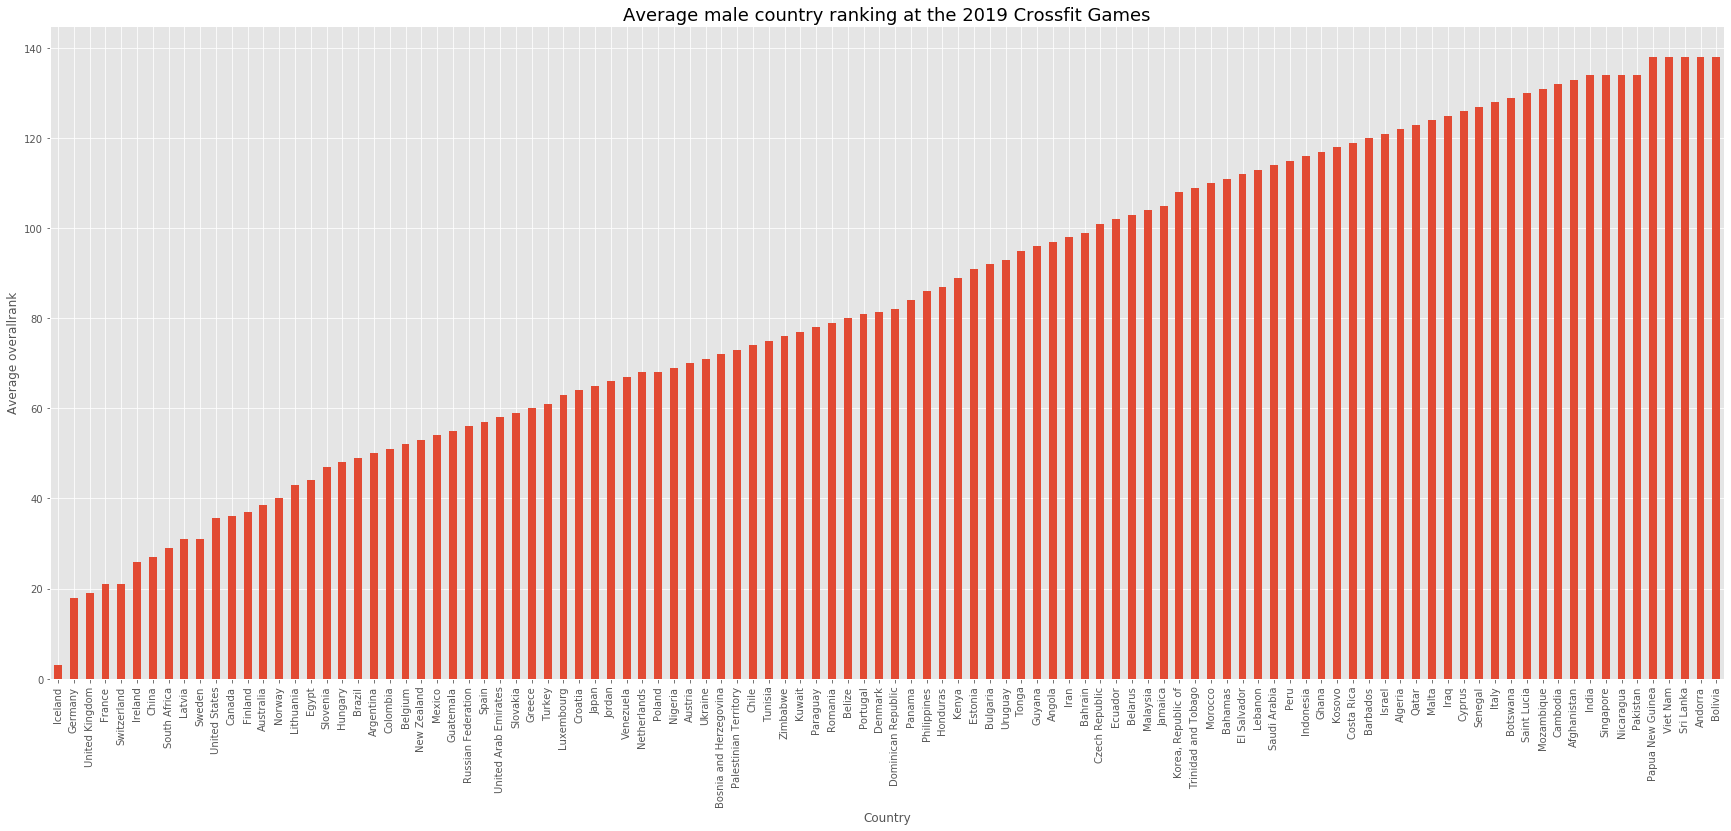

In [655]:
meanCountryRankMales = df_cfgMales.groupby('countryOfOriginName').mean()
meanCountryRankMales = meanCountryRankMales.sort_values(by=['overallRank'])
meanCountryRankMales['overallRank'].plot.bar(figsize=(30,12))
plt.title('Average male country ranking at the 2019 Crossfit Games', fontsize=18)
plt.ylabel('Average overallrank', fontsize=12)
plt.xlabel('Country', fontsize=12)
# saving the image
plt.savefig('meanCountryRankMales.png')
# showing the image
plt.show()

In [653]:
meanCountryRankMales['overallRank'].head(n=10)

countryOfOriginName
Iceland            3.0
Germany           18.0
United Kingdom    19.0
France            21.0
Switzerland       21.0
Ireland           26.0
China             27.0
South Africa      29.0
Latvia            31.0
Sweden            31.0
Name: overallRank, dtype: float64

#### For female competitors

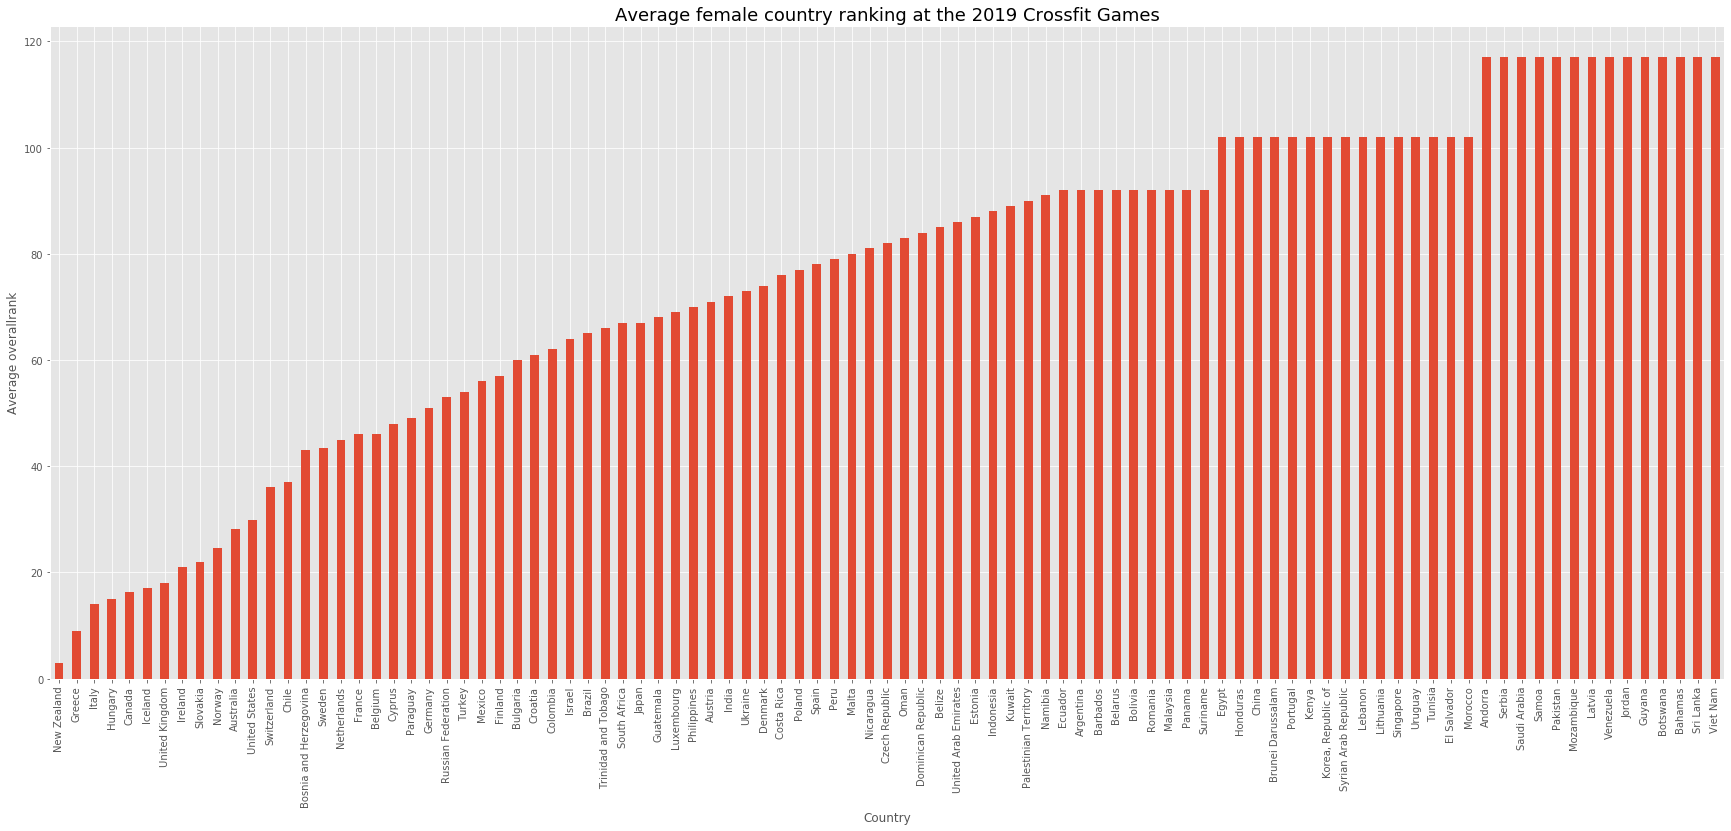

In [606]:
meanCountryRankFemales = df_cfgFemales.groupby('countryOfOriginName').mean()
meanCountryRankFemales = meanCountryRankFemales.sort_values(by=['overallRank'])
meanCountryRankFemales['overallRank'].plot.bar(figsize=(30,12))
plt.title('Average female country ranking at the 2019 Crossfit Games', fontsize=18)
plt.ylabel('Average overallrank', fontsize=12)
plt.xlabel('Country', fontsize=12)
# saving the image
plt.savefig('meanCountryRankFemales.png')
# showing the image
plt.show()

In [351]:
meanCountryRankFemals['overallRank'].head(n=10)

countryOfOriginName
New Zealand        3.000000
Greece             9.000000
Italy             14.000000
Hungary           15.000000
Canada            16.333333
Iceland           17.000000
United Kingdom    18.000000
Ireland           21.000000
Slovakia          22.000000
Norway            24.500000
Name: overallRank, dtype: float64

#### Combining male and female results

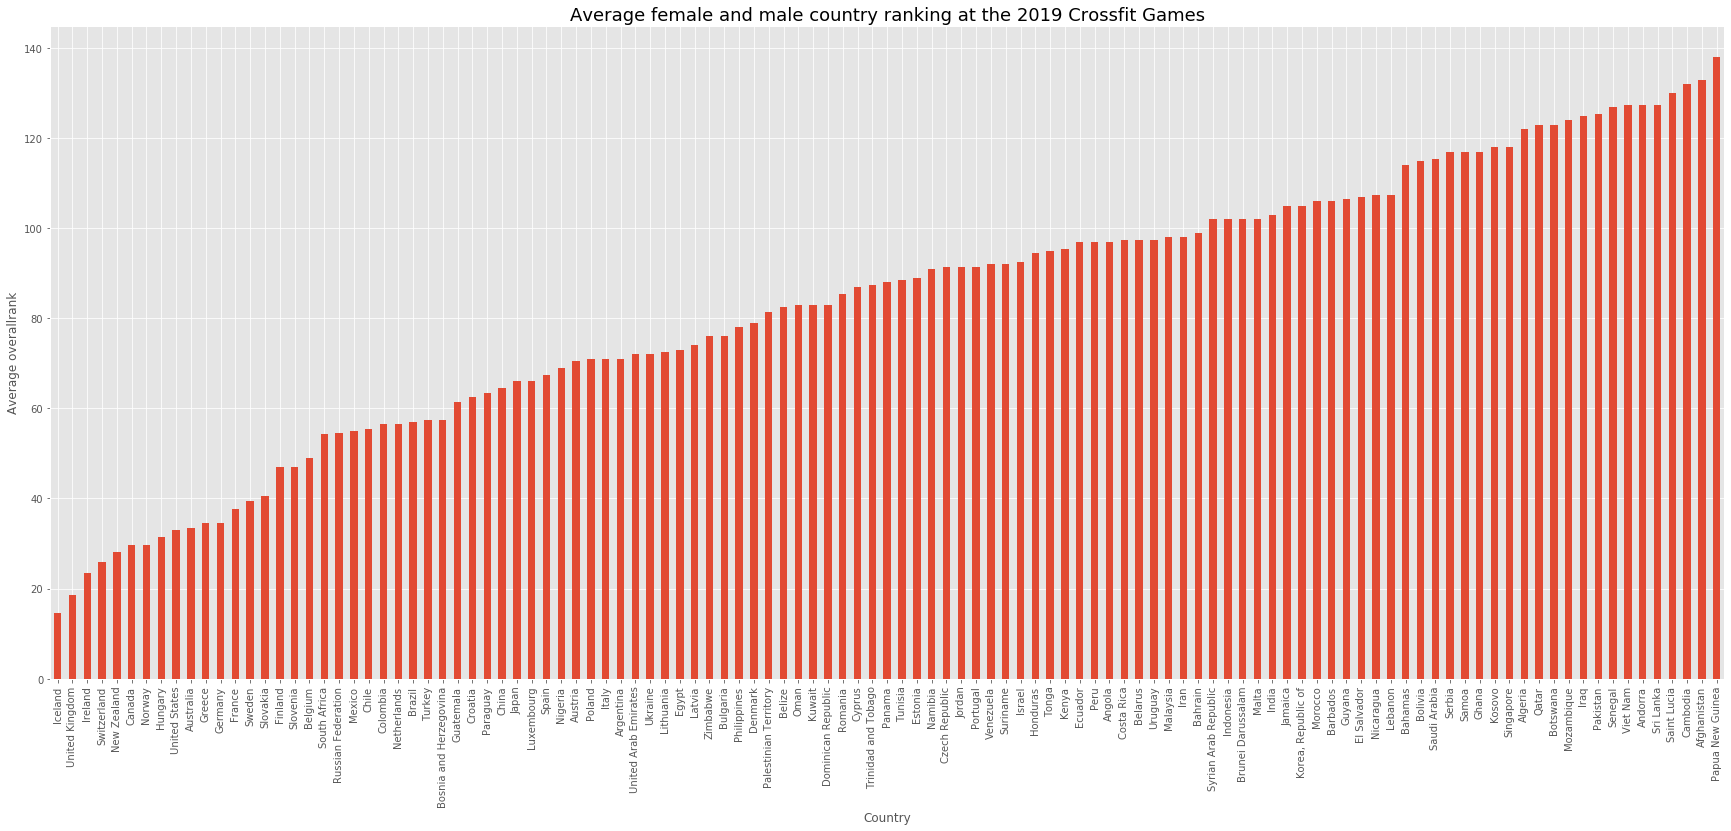

In [607]:
df = df_cfgFemales.append(df_cfgMales)
meanCountryRank = df.groupby('countryOfOriginName').mean()
meanCountryRank = meanCountryRank.sort_values(by=['overallRank'])
meanCountryRank['overallRank'].plot.bar(figsize=(30,12))
plt.title('Average female and male country ranking at the 2019 Crossfit Games', fontsize=18)
plt.ylabel('Average overallrank', fontsize=12)
plt.xlabel('Country', fontsize=12)
# saving the image
plt.savefig('meanCountryRankFem.png')
# showing the image
plt.show()

In [343]:
meanCountryRank['overallRank'].head(n=10)

countryOfOriginName
Iceland           14.666667
United Kingdom    18.500000
Ireland           23.500000
Switzerland       26.000000
New Zealand       28.000000
Canada            29.555556
Norway            29.666667
Hungary           31.500000
United States     33.063830
Australia         33.375000
Name: overallRank, dtype: float64

#### Counting the number of competitors for each country

#### For the males

In [360]:
countCountriesMales = df_cfgMales.groupby('countryOfOriginName').count()
countCountriesMales = countCountriesMales.sort_values(by=['competitorName'],ascending=False)
countCountriesMales['competitorId'].head(n=10)

countryOfOriginName
United States    26
Canada            6
Australia         4
Denmark           2
Sweden            2
Switzerland       2
Poland            2
Nigeria           1
Philippines       1
Peru              1
Name: competitorId, dtype: int64

#### For the females

In [361]:
countCountriesFemales = df_cfgFemales.groupby('countryOfOriginName').count()
countCountriesFemales = countCountriesFemales.sort_values(by=['competitorName'],ascending=False)
countCountriesFemales['competitorId'].head(n=10)

countryOfOriginName
United States    21
Iceland           5
Australia         4
Sweden            4
Canada            3
Norway            2
France            2
South Africa      2
Philippines       1
Peru              1
Name: competitorId, dtype: int64

#### Combined females and males

In [365]:
df = df_cfgFemales.append(df_cfgMales)
countCountries = df.groupby('countryOfOriginName').count()
countCountries = countCountries.sort_values(by=['competitorName'],ascending=False)
countCountries['competitorId'].head(n=10)

countryOfOriginName
United States    47
Canada            9
Australia         8
Iceland           6
Sweden            6
Switzerland       3
Poland            3
South Africa      3
Denmark           3
France            3
Name: competitorId, dtype: int64

In [651]:
# how many unique countries?
a = df_cfgFemales.append(df_cfgMales)
len(a['countryOfOriginName'].unique())

113

### Comparing the weight of the competitors

In [672]:
df_cfgMales['weightInKg'].describe()

count    143.000000
mean      84.716783
std        6.736133
min       63.500000
25%       81.600000
50%       86.200000
75%       88.400000
max       98.900000
Name: weightInKg, dtype: float64

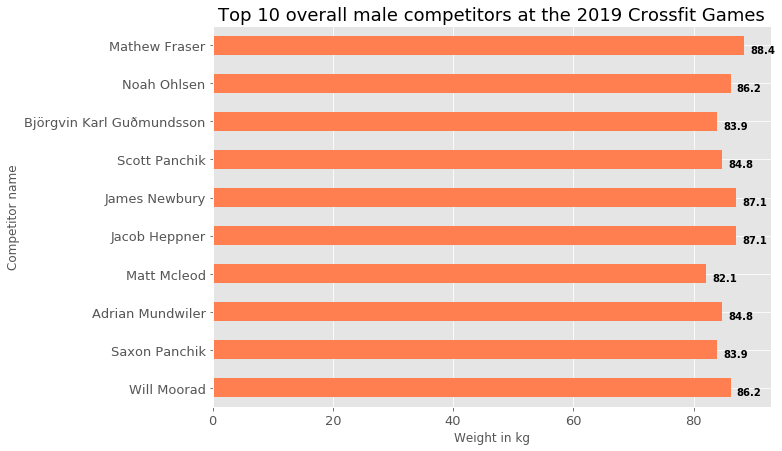

In [667]:
top10weightMales = df_cfgMales[(['competitorName','weightInKg','overallRank'])].sort_values(
    by=['overallRank'],ascending=True).head(n=10)

# plotting the results
plt.style.use('ggplot')
ax = top10weightMales.plot(kind='barh', x='competitorName', y='weightInKg',
                    color="coral", fontsize=13, figsize=(10,7))
ax.legend().remove()
plt.title('Top 10 overall male competitors at the 2019 Crossfit Games', fontsize=18)
plt.ylabel('Competitor name', fontsize=12)
plt.xlabel('Weight in kg', fontsize=12)
for i, v in enumerate(top10weightMales
                      ['weightInKg']):
     ax.text(v + 1, i + .2, str(v), fontweight='bold')
# invert for largest on top 
ax.invert_yaxis()
# saving the image
plt.savefig('top10weightMales.png', bbox_inches='tight')
plt.show()

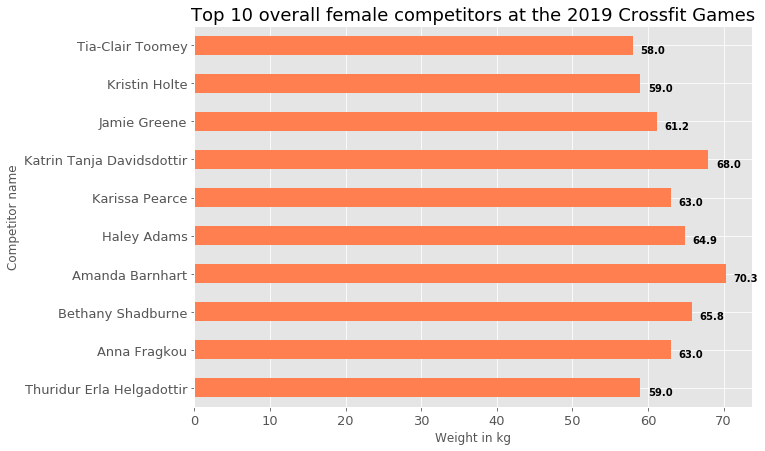

In [668]:
top10weightFemales = df_cfgFemales[(['competitorName','weightInKg','overallRank'])].sort_values(
    by=['overallRank'],ascending=True).head(n=10)

# plotting the results
plt.style.use('ggplot')
ax = top10weightFemales.plot(kind='barh', x='competitorName', y='weightInKg',
                    color="coral", fontsize=13, figsize=(10,7))
ax.legend().remove()
plt.title('Top 10 overall female competitors at the 2019 Crossfit Games', fontsize=18)
plt.ylabel('Competitor name', fontsize=12)
plt.xlabel('Weight in kg', fontsize=12)
for i, v in enumerate(top10weightFemales
                      ['weightInKg']):
     ax.text(v + 1, i + .2, str(v), fontweight='bold')
# invert for largest on top 
ax.invert_yaxis()
# saving the image
plt.savefig('top10weightFemales.png', bbox_inches='tight')
# showing the image
plt.show()

#### The heaviest male competitors at the 2019 Crossfit Games

count    143.000000
mean      84.716783
std        6.736133
min       63.500000
25%       81.600000
50%       86.200000
75%       88.400000
max       98.900000
Name: weightInKg, dtype: float64

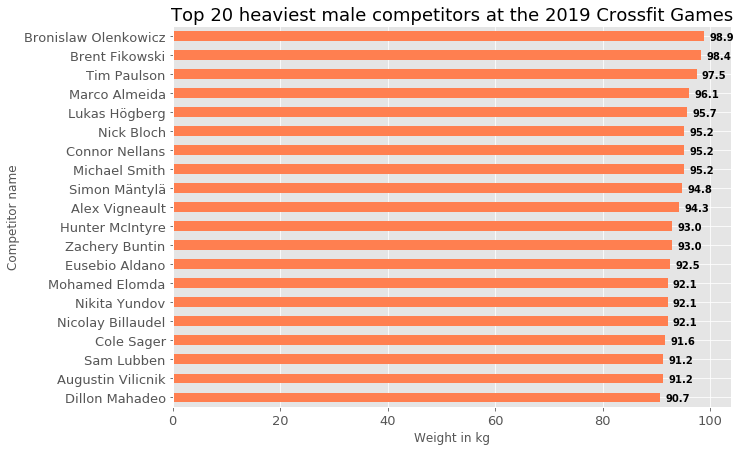

In [627]:
# sorting the males by weight
heavyMales = df_cfgMales[(['competitorName','weightInKg'])].sort_values(by=['weightInKg'],ascending=False)
top20WeightMales = heavyMales.head(n=20)

# plotting the results
plt.style.use('ggplot')
ax = top20WeightMales.plot(kind='barh', x='competitorName', y='weightInKg',
                    color="coral", fontsize=13, figsize=(10,7))
ax.legend().remove()
plt.title('Top 20 heaviest male competitors at the 2019 Crossfit Games', fontsize=18)
plt.ylabel('Competitor name', fontsize=12)
plt.xlabel('Weight in kg', fontsize=12)
for i, v in enumerate(top20WeightMales['weightInKg']):
     ax.text(v + 1, i + .2, str(v), fontweight='bold')
# invert for largest on top 
ax.invert_yaxis()
# saving the image
plt.savefig('top20WeightMales.png', bbox_inches='tight')
# showing the image
plt.show()

#### The heaviest female competitors at the 2019 Crossfit Games

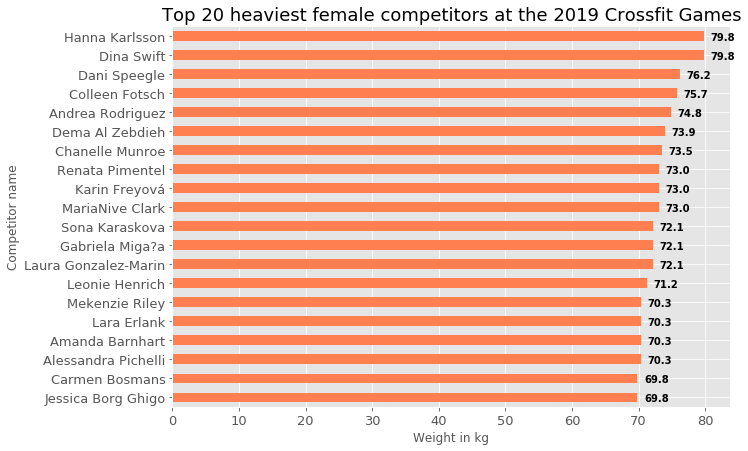

In [628]:
# sorting the females by weight
heavyFemales = df_cfgFemales[(['competitorName','weightInKg'])].sort_values(by=['weightInKg'],ascending=False)
top20WeightFemales = heavyFemales.head(n=20)

# plotting the results
plt.style.use('ggplot')  
ax = top20WeightFemales.plot(kind='barh', x='competitorName', y='weightInKg',
                      figsize=(10,7), color="coral", fontsize=13, )
ax.legend().remove()
plt.title('Top 20 heaviest female competitors at the 2019 Crossfit Games', fontsize=18)
plt.ylabel('Competitor name', fontsize=12)
plt.xlabel('Weight in kg', fontsize=12)
for i, v in enumerate(top20WeightFemales['weightInKg']):
    ax.text(v + 1, i + .2, str(v), fontweight='bold')
# invert for largest on top 
ax.invert_yaxis()
# saving the image
plt.savefig('top20WeightFemales.png', bbox_inches='tight')
# showing the image
plt.show()

#### The lightest male competitors at the 2019 Crossfit Games


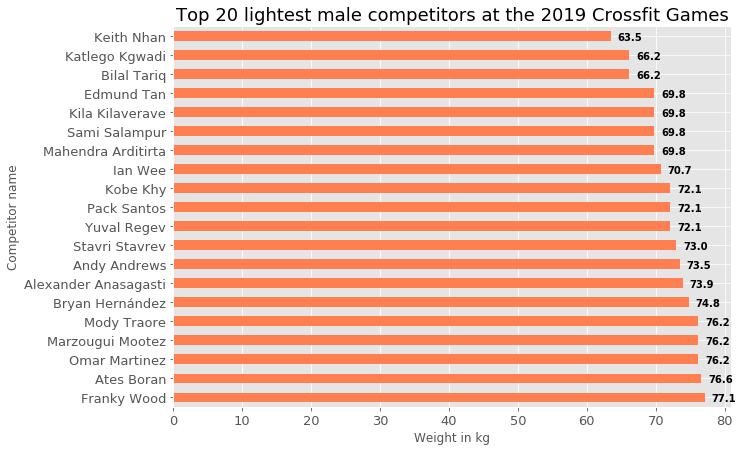

In [629]:
# sorting the males by weight
lightMales = df_cfgMales[(['competitorName','weightInKg'])].sort_values(by=['weightInKg'],ascending=True)
bottom20WeightMales = lightMales.head(n=20)

# plotting the results
plt.style.use('ggplot')  
ax = bottom20WeightMales.plot(kind='barh', x='competitorName', y='weightInKg',
                      figsize=(10,7), color="coral", fontsize=13, )
ax.legend().remove()
plt.title('Top 20 lightest male competitors at the 2019 Crossfit Games', fontsize=18)
plt.ylabel('Competitor name', fontsize=12)
plt.xlabel('Weight in kg', fontsize=12)
for i, v in enumerate(bottom20WeightMales['weightInKg']):
    ax.text(v + 1, i + .2, str(v), fontweight='bold')
# invert for largest on top 
ax.invert_yaxis()
# saving the image
plt.savefig('bottom20WeightMales.png', bbox_inches='tight')
# showing the image
plt.show()

#### The lightest female competitors at the 2019 Crossfit Games

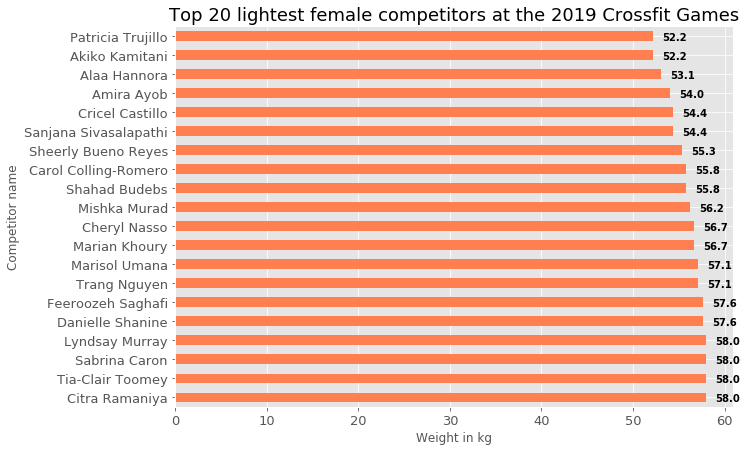

In [630]:
# sorting the males by weight
lightFemales = df_cfgFemales[(['competitorName','weightInKg'])].sort_values(by=['weightInKg'],ascending=True)
bottom20WeightFemales = lightFemales.head(n=20)

# plotting the results
plt.style.use('ggplot')  
ax = bottom20WeightFemales.plot(kind='barh', x='competitorName', y='weightInKg',
                      figsize=(10,7), color="coral", fontsize=13, )
ax.legend().remove()
plt.title('Top 20 lightest female competitors at the 2019 Crossfit Games', fontsize=18)
plt.ylabel('Competitor name', fontsize=12)
plt.xlabel('Weight in kg', fontsize=12)
for i, v in enumerate(bottom20WeightFemales['weightInKg']):
    ax.text(v + 1, i + .2, str(v), fontweight='bold')
# invert for largest on top 
ax.invert_yaxis()
# saving the image
plt.savefig('bottom20WeightFemales.png', bbox_inches='tight')
# showing the image
plt.show()

### Comparing the height of the competitors

In [671]:
df_cfgMales['heightInCm'].describe()

count    143.000000
mean     172.814685
std       24.498525
min        2.500000
25%      172.700000
50%      175.300000
75%      180.300000
max      188.000000
Name: heightInCm, dtype: float64

In [674]:
df_cfgFemales['heightInCm'].describe()

count    130.000000
mean     158.867692
std       30.311479
min        2.500000
25%      160.000000
50%      165.100000
75%      170.200000
max      177.800000
Name: heightInCm, dtype: float64

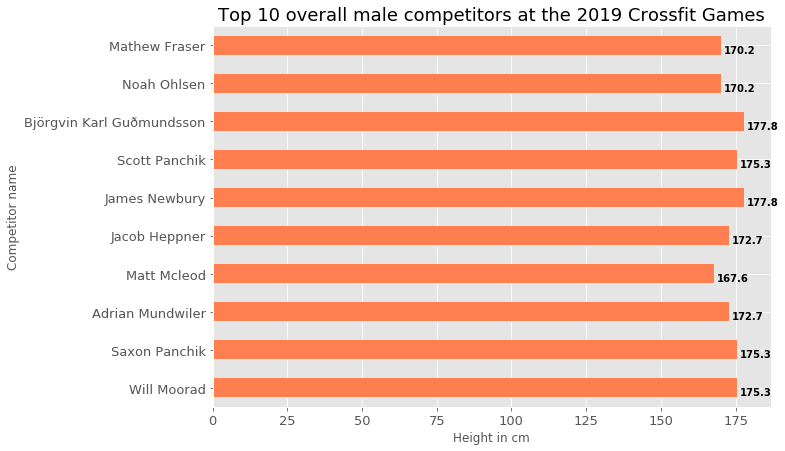

In [673]:
top10weightMales = df_cfgMales[(['competitorName','heightInCm','overallRank'])].sort_values(
    by=['overallRank'],ascending=True).head(n=10)

# plotting the results
plt.style.use('ggplot')
ax = top10weightMales.plot(kind='barh', x='competitorName', y='heightInCm',
                    color="coral", fontsize=13, figsize=(10,7))
ax.legend().remove()
plt.title('Top 10 overall male competitors at the 2019 Crossfit Games', fontsize=18)
plt.ylabel('Competitor name', fontsize=12)
plt.xlabel('Height in cm', fontsize=12)
for i, v in enumerate(top10weightMales
                      ['heightInCm']):
     ax.text(v + 1, i + .2, str(v), fontweight='bold')
# invert for largest on top 
ax.invert_yaxis()
# saving the image
plt.savefig('top10heightMales.png', bbox_inches='tight')
plt.show()

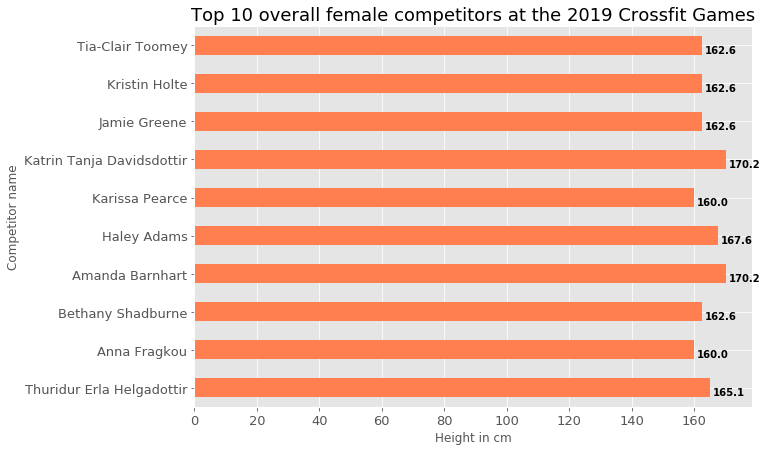

In [675]:
top10weightFemales = df_cfgFemales[(['competitorName','heightInCm','overallRank'])].sort_values(
    by=['overallRank'],ascending=True).head(n=10)

# plotting the results
plt.style.use('ggplot')
ax = top10weightFemales.plot(kind='barh', x='competitorName', y='heightInCm',
                    color="coral", fontsize=13, figsize=(10,7))
ax.legend().remove()
plt.title('Top 10 overall female competitors at the 2019 Crossfit Games', fontsize=18)
plt.ylabel('Competitor name', fontsize=12)
plt.xlabel('Height in cm', fontsize=12)
for i, v in enumerate(top10weightFemales
                      ['heightInCm']):
     ax.text(v + 1, i + .2, str(v), fontweight='bold')
# invert for largest on top 
ax.invert_yaxis()
# saving the image
plt.savefig('top10heightFemales.png', bbox_inches='tight')
plt.show()

#### The tallest male competitors at the 2019 Crossfit Games

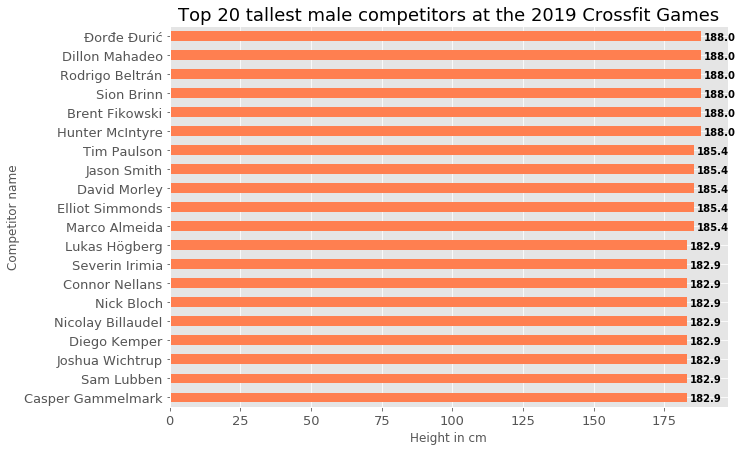

In [631]:
# sorting the males by height
tallMales = df_cfgMales[(['competitorName','heightInCm'])].sort_values(by=['heightInCm'],ascending=False)
top20TallestMales = tallMales.head(n=20)

# plotting the results
plt.style.use('ggplot')  
ax = top20TallestMales.plot(kind='barh', x='competitorName', y='heightInCm',
                      figsize=(10,7), color="coral", fontsize=13, )
ax.legend().remove()
plt.title('Top 20 tallest male competitors at the 2019 Crossfit Games', fontsize=18)
plt.ylabel('Competitor name', fontsize=12)
plt.xlabel('Height in cm', fontsize=12)
for i, v in enumerate(top20TallestMales['heightInCm']):
    ax.text(v + 1, i + .2, str(v), fontweight='bold')
# invert for largest on top 
ax.invert_yaxis()
# saving the image
plt.savefig('top20TallestMales.png', bbox_inches='tight')
# showing the image
plt.show()

#### The tallest female competitors at the 2019 Crossfit Games


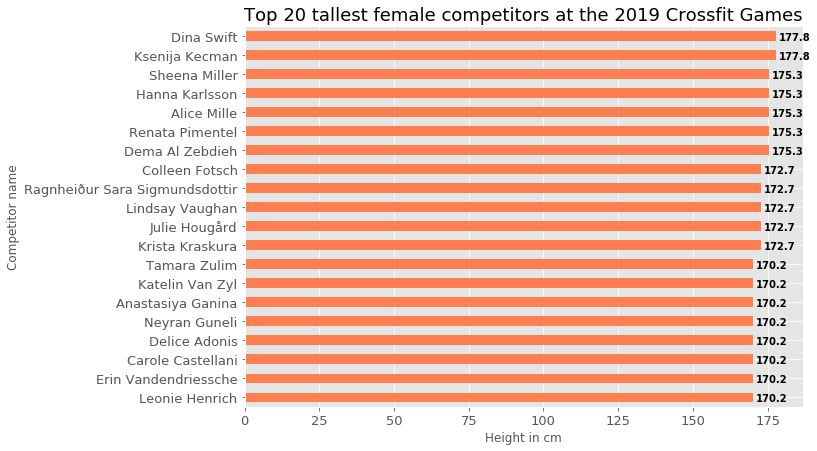

In [632]:
# sorting the females by height
tallFemales = df_cfgFemales[(['competitorName','heightInCm'])].sort_values(by=['heightInCm'],ascending=False)
top20TallestFemales = tallFemales.head(n=20)

# plotting the results
plt.style.use('ggplot')  
ax = top20TallestFemales.plot(kind='barh', x='competitorName', y='heightInCm',
                      figsize=(10,7), color="coral", fontsize=13, )
ax.legend().remove()
plt.title('Top 20 tallest female competitors at the 2019 Crossfit Games', fontsize=18)
plt.ylabel('Competitor name', fontsize=12)
plt.xlabel('Height in cm', fontsize=12)
for i, v in enumerate(top20TallestFemales['heightInCm']):
    ax.text(v + 1, i + .2, str(v), fontweight='bold')
# invert for largest on top 
ax.invert_yaxis()
# saving the image
plt.savefig('top20TallestFemales.png', bbox_inches='tight')
# showing the image
plt.show()

#### The smallest male competitors at the 2019 Crossfit Games

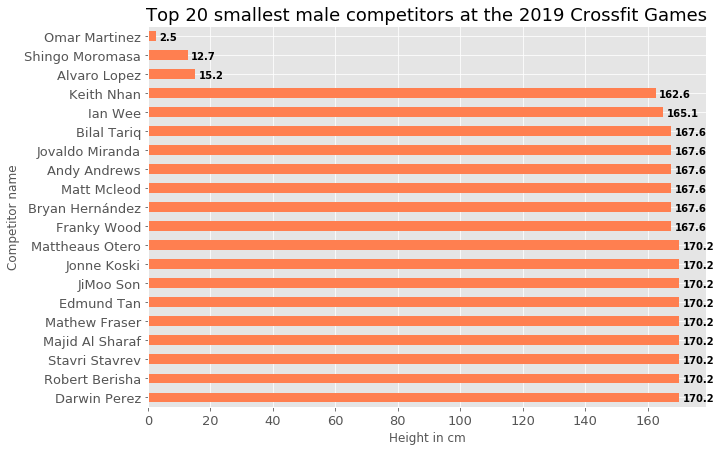

In [678]:
# sorting the males by height
smallMales = df_cfgMales[(['competitorName','heightInCm'])].sort_values(by=['heightInCm'],ascending=True)
bottom20TallestMales = smallMales.head(n=20)

# plotting the results
plt.style.use('ggplot')  
ax = bottom20TallestMales.plot(kind='barh', x='competitorName', y='heightInCm',
                      figsize=(10,7), color="coral", fontsize=13)
ax.legend().remove()
plt.title('Top 20 smallest male competitors at the 2019 Crossfit Games', fontsize=18)
plt.ylabel('Competitor name', fontsize=12)
plt.xlabel('Height in cm', fontsize=12)
for i, v in enumerate(bottom20TallestMales['heightInCm']):
    ax.text(v + 1, i + .2, str(v), fontweight='bold')
# invert for largest on top 
ax.invert_yaxis()
# saving the image
plt.savefig('top20SmallestMales.png', bbox_inches='tight')
# showing the image
plt.show()

**Some data quality issues!**

#### The smallest female competitors at the 2019 Crossfit Games

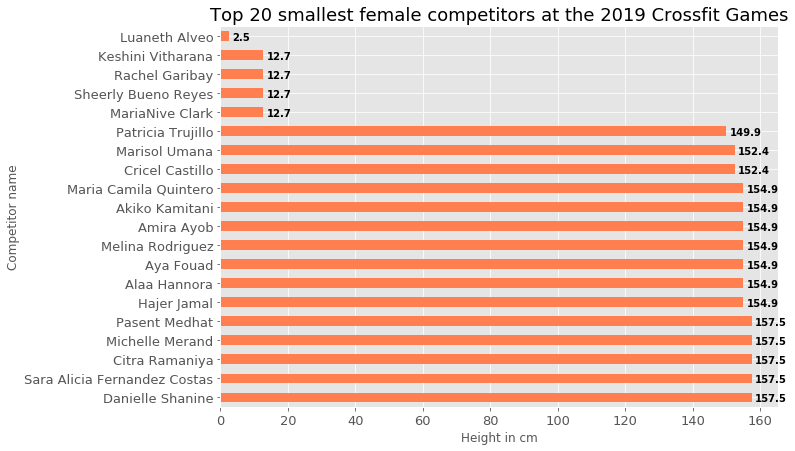

In [657]:
# sorting the females by height
smallFemales = df_cfgFemales[(['competitorName','heightInCm'])].sort_values(by=['heightInCm'],ascending=True)
bottom20TallestFemales = smallFemales.head(n=20)

# plotting the results
plt.style.use('ggplot')  
ax = bottom20TallestFemales.plot(kind='barh', x='competitorName', y='heightInCm',
                      figsize=(10,7), color="coral", fontsize=13)
ax.legend().remove()
plt.title('Top 20 smallest female competitors at the 2019 Crossfit Games', fontsize=18)
plt.ylabel('Competitor name', fontsize=12)
plt.xlabel('Height in cm', fontsize=12)
for i, v in enumerate(bottom20TallestFemales['heightInCm']):
    ax.text(v + 1, i + .2, str(v), fontweight='bold')
# invert for largest on top 
ax.invert_yaxis()
# saving the image
plt.savefig('top20SmallestFemales.png', bbox_inches='tight')
# showing the image
plt.show()

**Some data quality issues!**

### Comparing the height and weight of the competitors

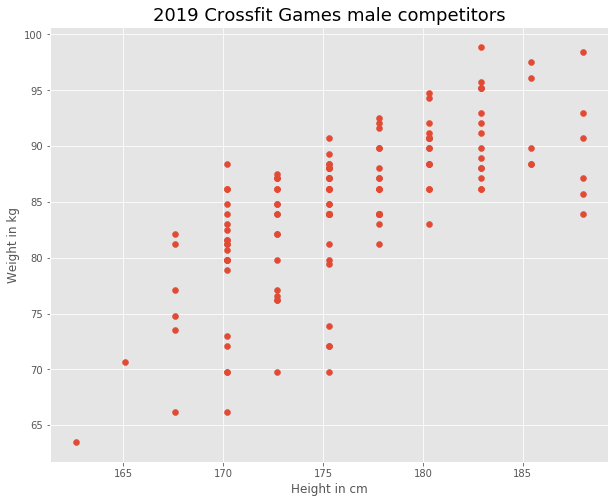

In [636]:
# some data quality issues for some competitors height data,
# so I only take those that have a height listed over 100 cm
cleanedHeight = df_cfgMales[df_cfgMales['heightInCm'] > 100]
plt.figure(figsize=(10,8))
plt.style.use('ggplot')
plt.scatter(cleanedHeight['heightInCm'],cleanedHeight['weightInKg'])
plt.title('2019 Crossfit Games male competitors', fontsize=18)
plt.ylabel('Weight in kg')
plt.xlabel('Height in cm')
plt.savefig('heightAndweightMales.png')
# saving the image
plt.savefig('weightVsHeightMales.png', bbox_inches='tight')
# showing the image
plt.show()

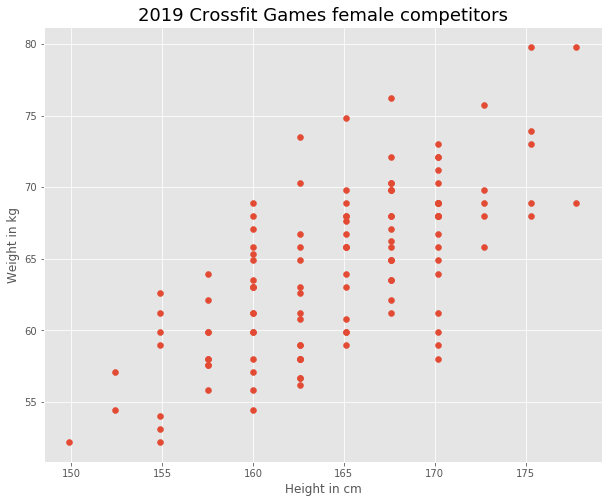

In [637]:
# some data quality issues for some competitors height data,
# so I only take those that have a height listed over 100 cm
cleanedHeight = df_cfgFemales[df_cfgFemales['heightInCm'] > 100]
plt.figure(figsize=(10,8))
plt.scatter(cleanedHeight['heightInCm'],cleanedHeight['weightInKg'])
plt.title('2019 Crossfit Games female competitors', fontsize=18)
plt.ylabel('Weight in kg')
plt.xlabel('Height in cm')
# saving the image
plt.savefig('weightVsHeightFemales.png', bbox_inches='tight')
# showing the image
plt.show()

I guess a basic linear relationship between weight and height ...

### Can we spot some linear trend between e.g. height and overallrank at the 2019 Crossfit Games?

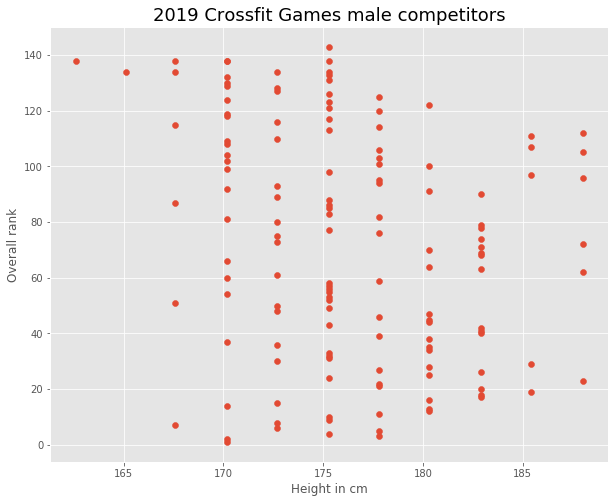

In [638]:
# some data quality issues for some competitors height data,
# so I only take those that have a height listed over 100 cm
cleanedHeight = df_cfgMales[df_cfgMales['heightInCm'] > 100]
plt.figure(figsize=(10,8))
plt.scatter(cleanedHeight['heightInCm'],cleanedHeight['overallRank'])
plt.title('2019 Crossfit Games male competitors', fontsize=18)
plt.ylabel('Overall rank')
plt.xlabel('Height in cm')
# saving the image
plt.savefig('overallrankVsHeightMales.png', bbox_inches='tight')
# showing the image
plt.show()

uuuhm not from this ...

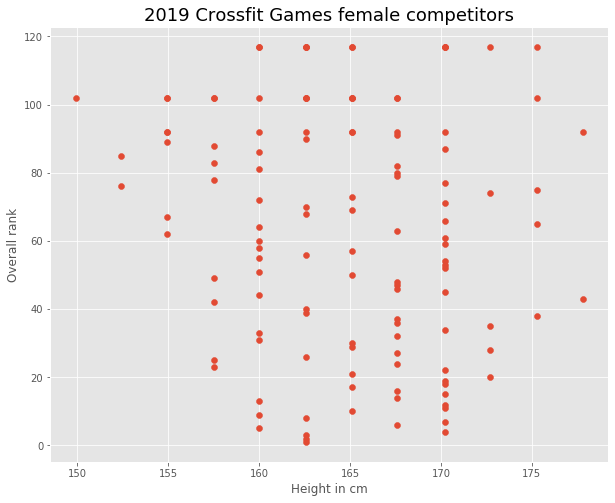

In [639]:
# some data quality issues for some competitors height data,
# so I only take those that have a height listed over 100 cm
cleanedHeight = df_cfgFemales[df_cfgFemales['heightInCm'] > 100]
plt.figure(figsize=(10,8))
plt.scatter(cleanedHeight['heightInCm'],cleanedHeight['overallRank'])
plt.title('2019 Crossfit Games female competitors', fontsize=18)
plt.ylabel('Overall rank')
plt.xlabel('Height in cm')
# saving the image
plt.savefig('overallrankVsHeightFemales.png', bbox_inches='tight')
# showing the image
plt.show()

and not from this ...

Hard to infer anything from this since we had the cuts.

### What about using the performance from event 5, Mary?

*where we sort of know that the event favours a shorter athelete ...*

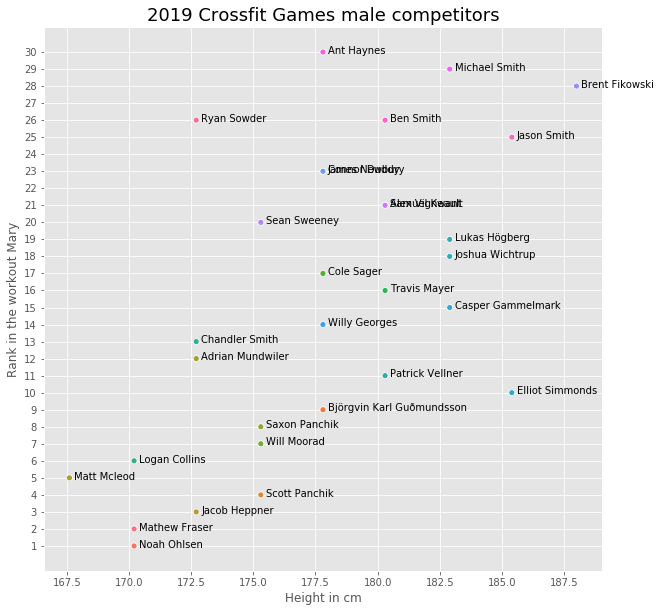

In [677]:
# some data quality issues for some competitors height data,
# so I only take those that have a height listed over 100 cm
cleanedHeight = df_cfgMales[df_cfgMales['heightInCm'] > 100]
event = df_cfgMalesEvents[df_cfgMalesEvents['event'] == 5]
df = pd.merge(event, cleanedHeight,how='inner',on='competitorId')
# plotting
f, ax = plt.subplots(figsize=(10,10))
g = sns.scatterplot(x='heightInCm',y='workoutRank',data=df,hue='competitorName',ax=ax)
plt.title('2019 Crossfit Games male competitors', fontsize=18)
plt.ylabel('Rank in the workout Mary')
plt.xlabel('Height in cm')
plt.yticks(np.arange(min(df['workoutRank']), max(df['workoutRank'])+1, 1))
# removing label
g.legend_.remove()

# function to write competitorName to datapoints
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.2, point['y']-0.1, str(point['val']))

# calling function        
label_point(df.heightInCm, df.workoutRank, df.competitorName, plt.gca())
# saving the image
plt.savefig('maryrankVsHeightMales.png', bbox_inches='tight')
# showing the image
plt.show()

In [314]:
print('The winner of Mary was')
print(df[df['workoutRank'] == 1][(['competitorName','heightInCm'])])
print('\n')
print('Last place in Mary was')
print(df[df['workoutRank'] == 30][(['competitorName','heightInCm'])])

The winner of Mary was
  competitorName  heightInCm
1    Noah Ohlsen       170.2


Last place in Mary was
   competitorName  heightInCm
26     Ant Haynes       177.8


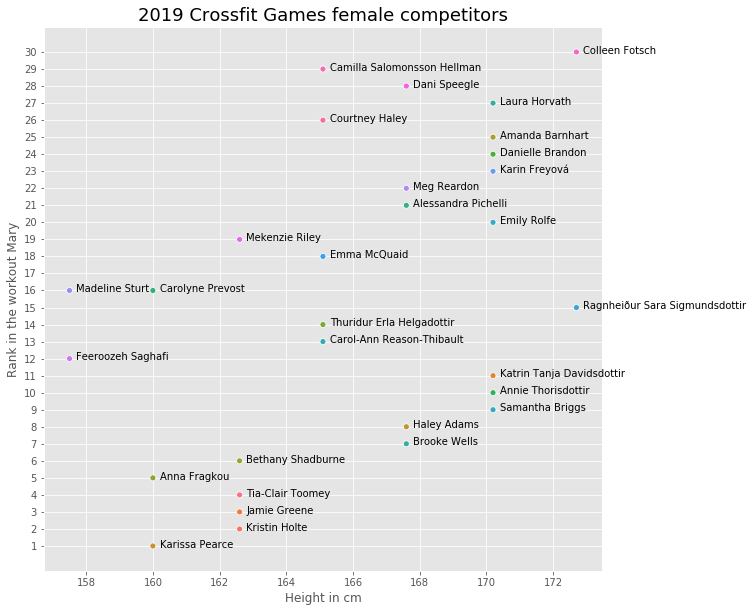

In [676]:
# some data quality issues for some competitors height data,
# so I only take those that have a height listed over 100 cm
cleanedHeight = df_cfgFemales[df_cfgFemales['heightInCm'] > 100]
event = df_cfgFemalesEvents[df_cfgFemalesEvents['event'] == 5]
df = pd.merge(event, cleanedHeight,how='inner',on='competitorId')
# plotting
f, ax = plt.subplots(figsize=(10,10))
g = sns.scatterplot(x='heightInCm',y='workoutRank',data=df,hue='competitorName',ax=ax)
plt.title('2019 Crossfit Games female competitors', fontsize=18)
plt.ylabel('Rank in the workout Mary')
plt.xlabel('Height in cm')
plt.yticks(np.arange(min(df['workoutRank']), max(df['workoutRank'])+1, 1))
# removing label
g.legend_.remove()

# function to write competitorName to datapoints
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.2, point['y']-0.1, str(point['val']))

# calling function        
label_point(df.heightInCm, df.workoutRank, df.competitorName, plt.gca())
# saving the image
plt.savefig('maryrankVsHeightFemales.png', bbox_inches='tight')
# showing the image
plt.show()

In [330]:
print('The winner of Mary was')
print(df[df['workoutRank'] == 1][(['competitorName','heightInCm'])])
print('\n')
print('Last place in Mary was')
print(df[df['workoutRank'] == 30][(['competitorName','heightInCm'])])

The winner of Mary was
   competitorName  heightInCm
4  Karissa Pearce       160.0


Last place in Mary was
    competitorName  heightInCm
27  Colleen Fotsch       172.7


### Comparing  Mat's and Tia's performance

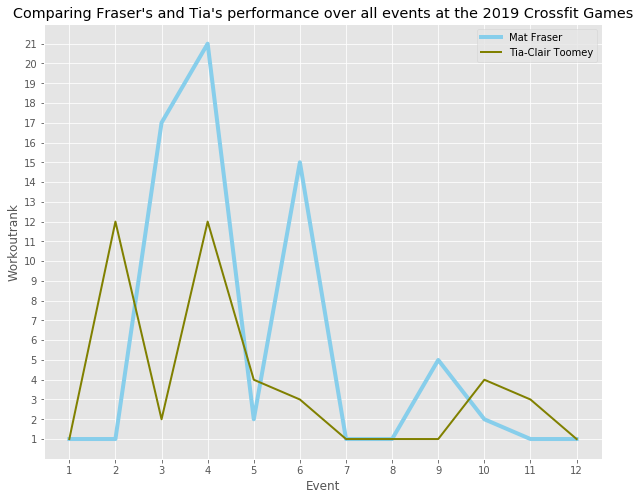

In [642]:
matt = df_cfgMalesEvents[df_cfgMalesEvents['competitorId'] == '153604'][(['event','workoutRank'])]
tia = df_cfgFemalesEvents[df_cfgFemalesEvents['competitorId'] == '163097'][(['event','workoutRank'])]
# multiple line plot
plt.figure(figsize=(10,8))
plt.plot( 'event', 'workoutRank', data=matt, marker='', label = 'Mat Fraser',
         markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'event', 'workoutRank', data=tia, label = 'Tia-Clair Toomey',
         marker='', color='olive', linewidth=2)
plt.yticks(np.arange(min(matt['workoutRank']), max(matt['workoutRank'])+1, 1))
plt.xticks(np.arange(min(matt['event']), max(matt['event'])+1, 1))
plt.legend()
plt.title("Comparing Fraser's and Tia's performance over all events at the 2019 Crossfit Games")
plt.xlabel('Event')
plt.ylabel('Workoutrank')
# saving the image
plt.savefig('matVsTia.png', bbox_inches='tight')
# showing the image
plt.show()

Tia's lowest rank were two 12th place finishes while Fraser's worst finish was a 21st place in event 4.Tia won the female competition with a 195 points while Fraser only won by a 35 points.

# The Cuts

**Let's explore some different scenarios for eacth of the six cuts at the 2019 Crossfit Games!**

## Males

### The second cut

#### What guys would have made it trough the second cut if the scores would have been reset after the first cut

In [679]:
totalPointsForEventTwoMales = df_cfgMalesEvents[df_cfgMalesEvents['event'] == 2]
totalPointsForEventTwoMales = totalPointsForEventTwoMales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventTwoMales = totalPointsForEventTwoMales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventTwoMales = pd.merge(totalPointsForEventTwoMales, df_cfgMales, on='competitorId', how='inner')
totalPointsForEventTwoMalesMadeIt = totalPointsForEventTwoMales[(totalPointsForEventTwoMales['overallRank'] > 50) & 
                                                      (totalPointsForEventTwoMales['workoutRank'] <= 50) &
                                               (totalPointsForEventTwoMales['workoutRank'] != 0)]
print(totalPointsForEventTwoMalesMadeIt[(['competitorName','overallRank','workoutRank'])])

     competitorName  overallRank  workoutRank
27   Connor Nellans           63           49
33        Erik Toth           59           43
37  Bryan Hernández           51           39
39   Marlon Azurdia           55           37


#### What guys would have been cut if the scores would have been reset after the first cut

In [680]:
totalPointsForEventTwoMales = df_cfgMalesEvents[df_cfgMalesEvents['event'] == 2]
totalPointsForEventTwoMales = totalPointsForEventTwoMales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventTwoMales = totalPointsForEventTwoMales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventTwoMales = pd.merge(totalPointsForEventTwoMales, df_cfgMales, on='competitorId', how='inner')
totalPointsForEventTwoMalesCut = totalPointsForEventTwoMales[(totalPointsForEventTwoMales['overallRank'] <= 50) & 
                                                      (totalPointsForEventTwoMales['workoutRank'] > 50) &
                                               (totalPointsForEventTwoMales['workoutRank'] != 0)]
print(totalPointsForEventTwoMalesCut[(['competitorName','overallRank','workoutRank'])])

         competitorName  overallRank  workoutRank
1           Jason Smith           29           73
19  Guilherme Malheiros           49           57
22        Jason Carroll           39           54
23        Willy Georges           21           53


### The third cut

#### What guys would have made it trough the the third cut if the scores would have been reset after the second cut

In [681]:
totalPointsForEventThreeMales = df_cfgMalesEvents[df_cfgMalesEvents['event'] == 3]
totalPointsForEventThreeMales = totalPointsForEventThreeMales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventThreeMales = totalPointsForEventThreeMales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventThreeMales = pd.merge(totalPointsForEventThreeMales, df_cfgMales, on='competitorId', how='inner')
totalPointsForEventThreeMalesMadeIt = totalPointsForEventThreeMales[(totalPointsForEventThreeMales['overallRank'] > 40) & 
                                                      (totalPointsForEventThreeMales['workoutRank'] <= 40) &
                                               (totalPointsForEventThreeMales['workoutRank'] != 0)]
print(totalPointsForEventThreeMalesMadeIt[(['competitorName','overallRank','workoutRank'])])

        competitorName  overallRank  workoutRank
10         Gábor Török           48           40
12  John-Paul Hethcock           46           38
13      Mohamed Elomda           44           37
15  Arminas Balevicius           43           35
20          Nick Bloch           41           30


#### What guys would have been cut after event three if scores would have been reset after the second cut

In [682]:
totalPointsForEventThreeMales = df_cfgMalesEvents[df_cfgMalesEvents['event'] == 3]
totalPointsForEventThreeMales = totalPointsForEventThreeMales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventThreeMales = totalPointsForEventThreeMales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventThreeMales = pd.merge(totalPointsForEventThreeMales, df_cfgMales, on='competitorId', how='inner')
totalPointsForEventThreeMalesCut = totalPointsForEventThreeMales[(totalPointsForEventThreeMales['overallRank'] <= 40) & 
                                                      (totalPointsForEventThreeMales['workoutRank'] > 40) &
                                               (totalPointsForEventThreeMales['workoutRank'] != 0)]
print(totalPointsForEventThreeMalesCut[(['competitorName','overallRank','workoutRank'])])

     competitorName  overallRank  workoutRank
4     Saxon Panchik            9           46
6     Logan Collins           14           44
7       Jonne Koski           37           43
8  Samuel Cournoyer           35           42
9     Scott Panchik            4           41


### The fourth cut

#### What guys would have made it trough the the fourth cut if scores would have been reset after the third cut

In [685]:
totalPointsForEventFourMales = df_cfgMalesEvents[df_cfgMalesEvents['event'] == 4]
totalPointsForEventFourMales = totalPointsForEventFourMales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventFourMales = totalPointsForEventFourMales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventFourMales = pd.merge(totalPointsForEventFourMales, df_cfgMales, on='competitorId', how='inner')
totalPointsForEventFourMalesMadeIt = totalPointsForEventFourMales[(totalPointsForEventFourMales['overallRank'] > 30) & 
                                                      (totalPointsForEventFourMales['workoutRank'] <= 30) &
                                               (totalPointsForEventFourMales['workoutRank'] != 0)]
print(totalPointsForEventFourMalesMadeIt[(['competitorName','overallRank','workoutRank'])])

          competitorName  overallRank  workoutRank
10        Uldis Upenieks           31           30
12          Eric Carmody           38           28
15  Dean Linder-Leighton           36           25
17         Jason Carroll           39           23
29       Lukas Esslinger           34           11


#### What guys would have made been cut after the fourth event if scores would have been reset after the third cut

In [686]:
totalPointsForEventFourMales = df_cfgMalesEvents[df_cfgMalesEvents['event'] == 4]
totalPointsForEventFourMales = totalPointsForEventFourMales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventFourMales = totalPointsForEventFourMales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventFourMales = pd.merge(totalPointsForEventFourMales, df_cfgMales, on='competitorId', how='inner')
totalPointsForEventFourMalesCut = totalPointsForEventFourMales[(totalPointsForEventFourMales['overallRank'] <= 30) & 
                                                      (totalPointsForEventFourMales['workoutRank'] > 30) &
                                               (totalPointsForEventFourMales['workoutRank'] != 0)]
print(totalPointsForEventFourMalesCut[(['competitorName','overallRank','workoutRank'])])

      competitorName  overallRank  workoutRank
0          Ben Smith           28           40
2       Travis Mayer           12           38
5    Patrick Vellner           16           35
8     Chandler Smith           15           32
9  Casper Gammelmark           20           31


### The fifth cut

#### What guys would have made it trough the the fifth cut if scores would have been reset after the fourth cut

In [687]:
totalPointsForEventFiveMales = df_cfgMalesEvents[df_cfgMalesEvents['event'] == 5]
totalPointsForEventFiveMales = totalPointsForEventFiveMales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventFiveMales = totalPointsForEventFiveMales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventFiveMales = pd.merge(totalPointsForEventFiveMales, df_cfgMales, on='competitorId', how='inner')
totalPointsForEventFiveMalesMadeIt = totalPointsForEventFiveMales[(totalPointsForEventFiveMales['overallRank'] > 20) & 
                                                      (totalPointsForEventFiveMales['workoutRank'] <= 20) &
                                               (totalPointsForEventFiveMales['workoutRank'] != 0)]
print(totalPointsForEventFiveMalesMadeIt[(['competitorName','overallRank','workoutRank'])])

   competitorName  overallRank  workoutRank
10   Sean Sweeney           24           20
16  Willy Georges           21           14


#### What guys would have been cut after the fifth event if scores would have been reset after the fourth cut

In [688]:
totalPointsForEventFiveMales = df_cfgMalesEvents[df_cfgMalesEvents['event'] == 5]
totalPointsForEventFiveMales = totalPointsForEventFiveMales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventFiveMales = totalPointsForEventFiveMales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventFiveMales = pd.merge(totalPointsForEventFiveMales, df_cfgMales, on='competitorId', how='inner')
totalPointsForEventFiveMalesCut = totalPointsForEventFiveMales[(totalPointsForEventFiveMales['overallRank'] <= 20) & 
                                                      (totalPointsForEventFiveMales['workoutRank'] > 20) &
                                               (totalPointsForEventFiveMales['workoutRank'] != 0)]
print(totalPointsForEventFiveMalesCut[(['competitorName','overallRank','workoutRank'])])

  competitorName  overallRank  workoutRank
7  James Newbury            5           23
8   Samuel Kwant           13           21


### The sixth cut

#### What guys would have made it trough the sixth cut if scores would have been reset after fifth cut

In [689]:
totalPointsForEventSixMales = df_cfgMalesEvents[df_cfgMalesEvents['event'] == 6]
totalPointsForEventSixMales = totalPointsForEventSixMales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventSixMales = totalPointsForEventSixMales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventSixMales = pd.merge(totalPointsForEventSixMales, df_cfgMales, on='competitorId', how='inner')
totalPointsForEventSixMalesMadeIt = totalPointsForEventSixMales[(totalPointsForEventSixMales['overallRank'] > 10) & 
                                                      (totalPointsForEventSixMales['workoutRank'] <= 10) &
                                               (totalPointsForEventSixMales['workoutRank'] != 0)]
print(totalPointsForEventSixMalesMadeIt[(['competitorName','overallRank','workoutRank'])])

     competitorName  overallRank  workoutRank
10  Joshua Wichtrup           18           10
12       Cole Sager           11            8
14     Travis Mayer           12            6


#### What guys would have been cut after the sixth event if scores would have been reset after the fifth cut

In [690]:
totalPointsForEventSixMales = df_cfgMalesEvents[df_cfgMalesEvents['event'] == 6]
totalPointsForEventSixMales = totalPointsForEventSixMales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventSixMales = totalPointsForEventSixMales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventSixMales = pd.merge(totalPointsForEventSixMales, df_cfgMales, on='competitorId', how='inner')
totalPointsForEventSixMalesCut = totalPointsForEventSixMales[(totalPointsForEventSixMales['overallRank'] <= 10) & 
                                                      (totalPointsForEventSixMales['workoutRank'] > 10) &
                                               (totalPointsForEventSixMales['workoutRank'] != 0)]
print(totalPointsForEventSixMalesCut[(['competitorName','overallRank','workoutRank'])])

     competitorName  overallRank  workoutRank
3     Jacob Heppner            6           17
5     Mathew Fraser            1           15
6  Adrian Mundwiler            8           13


### How the final rank would have been if the scoring would have been reset after the final cut

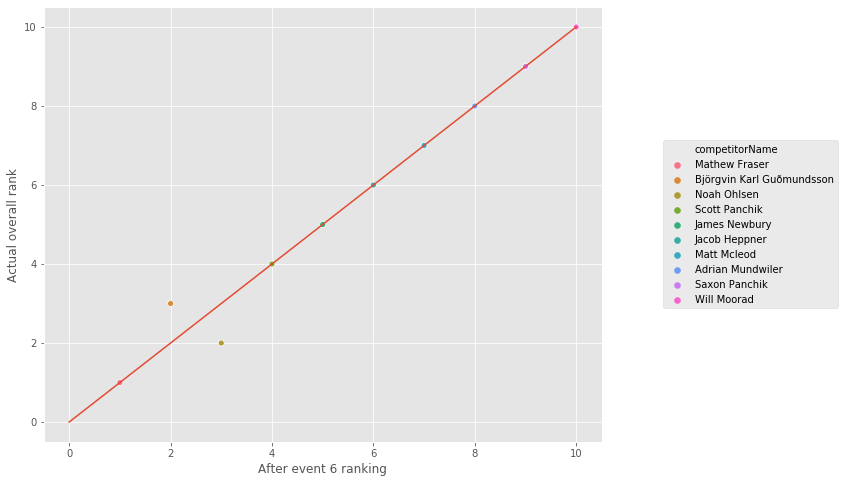

              competitorName  overallRank  afterEventSixRank  points
1  Björgvin Karl Guðmundsson            3                  2     470
2                Noah Ohlsen            2                  3     450


In [709]:
## summing competitor points after 6 events and comparing to final rank
totalPointsAfterSixEventsMales = df_cfgMalesEvents[df_cfgMalesEvents['event'] > 6]
# filtering out athletes that have been cut
totalPointsAfterSixEventsMales = totalPointsAfterSixEventsMales[totalPointsAfterSixEventsMales['points'] > 0]
totalPointsAfterSixEventsMales = totalPointsAfterSixEventsMales[(['competitorId','points'])].groupby('competitorId').sum()
totalPointsAfterSixEventsMales = totalPointsAfterSixEventsMales.sort_values(by=['points'],ascending=False)
# initializing the afterEventSixRank
value = 0
totalPointsAfterSixEventsMales['afterEventSixRank'] = value
# writting the afterEventSixRank into the dataframe
for i in range(0,len(totalPointsAfterSixEventsMales)):
    totalPointsAfterSixEventsMales['afterEventSixRank'].iloc[i] = 1 + i   
merged = pd.merge(totalPointsAfterSixEventsMales, df_cfgMales, on='competitorId', how='inner')
# plotting the results on a scatterplot, those that fall of the straight line are exceptions
f, ax = plt.subplots(figsize=(10,8))
g = sns.scatterplot(x='afterEventSixRank',y='overallRank',data=merged,hue='competitorName',ax=ax)
g.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)
# create a straight line and plot it
x = np.arange(0,11,1)
y = x
plt.plot(x, y, label='y=x')
#
plt.ylabel('Actual overall rank')
plt.xlabel('After event 6 ranking')
# saving the image
plt.savefig('overallrankVsFinal6Males.png', bbox_inches='tight')
# showing the image
plt.show()
# showing those that fall of the line
print(merged[(merged['afterEventSixRank']) != (merged['overallRank'])][(['competitorName','overallRank','afterEventSixRank','points'])])

In [708]:
totalPointsAfterSixEventsMales

,points,afterEventSixRank
competitorId,,
153604,550,1
81616,470,2
2725,450,3
34796,370,4
16080,340,5
199938,310,6
660204,270,7
698182,260,8
310970,200,9


#### BKG and Noah would have switched places!

## Females

### The second cut

#### What females would have made it trough the second cut if the scores would have been reset after the first cut

In [691]:
totalPointsForEventTwoFemales = df_cfgFemalesEvents[df_cfgFemalesEvents['event'] == 2]
totalPointsForEventTwoFemales = totalPointsForEventTwoFemales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventTwoFemales = totalPointsForEventTwoFemales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventTwoFemales = pd.merge(totalPointsForEventTwoFemales, df_cfgFemales, on='competitorId', how='inner')
totalPointsForEventTwoFemalesMadeIt = totalPointsForEventTwoFemales[(totalPointsForEventTwoFemales['overallRank'] > 50) & 
                                                      (totalPointsForEventTwoFemales['workoutRank'] <= 50) &
                                               (totalPointsForEventTwoFemales['workoutRank'] != 0)]
print(totalPointsForEventTwoFemalesMadeIt[(['competitorName','overallRank','workoutRank'])])

           competitorName  overallRank  workoutRank
28  Maria Camila Quintero           62           47
29            Brooke Haas           55           46
32              Lisa Eble           51           43
40   Erin Vandendriessche           52           35
43          Brenda Castro           56           32


#### What femals would have been cut if the scores would have been reset after the first cut

In [692]:
totalPointsForEventTwoFemales = df_cfgFemalesEvents[df_cfgFemalesEvents['event'] == 2]
totalPointsForEventTwoFemales = totalPointsForEventTwoFemales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventTwoFemales = totalPointsForEventTwoFemales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventTwoFemales = pd.merge(totalPointsForEventTwoFemales, df_cfgFemales, on='competitorId', how='inner')
totalPointsForEventTwoFemalesCut = totalPointsForEventTwoFemales[(totalPointsForEventTwoFemales['overallRank'] <= 50) & 
                                                      (totalPointsForEventTwoFemales['workoutRank'] > 50) &
                                               (totalPointsForEventTwoFemales['workoutRank'] != 0)]
print(totalPointsForEventTwoFemalesCut[(['competitorName','overallRank','workoutRank'])])

            competitorName  overallRank  workoutRank
8           Ksenija Kecman           43           67
13  Oddrún Eik Gylfadottir           39           60
16    Carol Colling-Romero           49           59
21     Thelma Christoforou           48           54
22            Cheryl Nasso           40           53


### The third cut

#### What females would have made it trough the the third cut if the scores would have been reset after the second cut

In [693]:
totalPointsForEventThreeFemales = df_cfgFemalesEvents[df_cfgFemalesEvents['event'] == 3]
totalPointsForEventThreeFemales = totalPointsForEventThreeFemales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventThreeFemales = totalPointsForEventThreeFemales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventThreeFemales = pd.merge(totalPointsForEventThreeFemales, df_cfgFemales, on='competitorId', how='inner')
totalPointsForEventThreeFemalesMadeIt = totalPointsForEventThreeFemales[(totalPointsForEventThreeFemales['overallRank'] > 40) & 
                                                      (totalPointsForEventThreeFemales['workoutRank'] <= 40) &
                                               (totalPointsForEventThreeFemales['workoutRank'] != 0)]
print(totalPointsForEventThreeFemalesMadeIt[(['competitorName','overallRank','workoutRank'])])

     competitorName  overallRank  workoutRank
12  Michelle Merand           42           38
14   Rachel Garibay           41           36
17   Ksenija Kecman           43           33


#### What females would have been cut after event three if scores would have been reset after the second cut

In [694]:
totalPointsForEventThreeFemales = df_cfgFemalesEvents[df_cfgFemalesEvents['event'] == 3]
totalPointsForEventThreeFemales = totalPointsForEventThreeFemales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventThreeFemales = totalPointsForEventThreeFemales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventThreeFemales = pd.merge(totalPointsForEventThreeFemales, df_cfgFemales, on='competitorId', how='inner')
totalPointsForEventThreeFemalesCut = totalPointsForEventThreeFemales[(totalPointsForEventThreeFemales['overallRank'] <= 40) & 
                                                      (totalPointsForEventThreeFemales['workoutRank'] > 40) &
                                               (totalPointsForEventThreeFemales['workoutRank'] != 0)]
print(totalPointsForEventThreeFemalesCut[(['competitorName','overallRank','workoutRank'])])

       competitorName  overallRank  workoutRank
6      Courtney Haley           30           44
8         Meg Reardon           24           42
9  Annie Thorisdottir           12           41


### The fourth cut

#### What females would have made it trough the the fourth cut if scores would have been reset after the third cut

In [695]:
totalPointsForEventFourFemales = df_cfgFemalesEvents[df_cfgFemalesEvents['event'] == 4]
totalPointsForEventFourFemales = totalPointsForEventFourFemales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventFourFemales = totalPointsForEventFourFemales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventFourFemales = pd.merge(totalPointsForEventFourFemales, df_cfgFemales, on='competitorId', how='inner')
totalPointsForEventFourFemalesMadeIt = totalPointsForEventFourFemales[(totalPointsForEventFourFemales['overallRank'] > 30) & 
                                                      (totalPointsForEventFourFemales['workoutRank'] <= 30) &
                                               (totalPointsForEventFourFemales['workoutRank'] != 0)]
print(totalPointsForEventFourFemalesMadeIt[(['competitorName','overallRank','workoutRank'])])

         competitorName  overallRank  workoutRank
11      Lindsay Vaughan           35           29
13        Paige Semenza           31           27
15  Alessia Joy Wälchli           36           25
18            Emma Tall           32           22


#### What females would have made been cut after the fourth event if scores would have been reset after the third cut

In [696]:
totalPointsForEventFourFemales = df_cfgFemalesEvents[df_cfgFemalesEvents['event'] == 4]
totalPointsForEventFourFemales = totalPointsForEventFourFemales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventFourFemales = totalPointsForEventFourFemales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventFourFemales = pd.merge(totalPointsForEventFourFemales, df_cfgFemales, on='competitorId', how='inner')
totalPointsForEventFourFemalesCut = totalPointsForEventFourFemales[(totalPointsForEventFourFemales['overallRank'] <= 30) & 
                                                      (totalPointsForEventFourFemales['workoutRank'] > 30) &
                                               (totalPointsForEventFourFemales['workoutRank'] != 0)]
print(totalPointsForEventFourFemalesCut[(['competitorName','overallRank','workoutRank'])])

      competitorName  overallRank  workoutRank
4     Mekenzie Riley           26           36
6        Haley Adams            6           34
8     Madeline Sturt           23           32
9  Feeroozeh Saghafi           25           31


### The fifth cut

#### What females would have made it trough the the fifth cut if scores would have been reset after the fourth cut

In [697]:
totalPointsForEventFiveFemales = df_cfgFemalesEvents[df_cfgFemalesEvents['event'] == 5]
totalPointsForEventFiveFemales = totalPointsForEventFiveFemales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventFiveFemales = totalPointsForEventFiveFemales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventFiveFemales = pd.merge(totalPointsForEventFiveFemales, df_cfgFemales, on='competitorId', how='inner')
totalPointsForEventFiveFemalesMadeIt = totalPointsForEventFiveFemales[(totalPointsForEventFiveFemales['overallRank'] > 20) & 
                                                      (totalPointsForEventFiveFemales['workoutRank'] <= 20) &
                                               (totalPointsForEventFiveFemales['workoutRank'] != 0)]
print(totalPointsForEventFiveFemalesMadeIt[(['competitorName','overallRank','workoutRank'])])

       competitorName  overallRank  workoutRank
11     Mekenzie Riley           26           19
12       Emma McQuaid           21           18
14     Madeline Sturt           23           16
18  Feeroozeh Saghafi           25           12


#### What females would have been cut after the fifth event if scores would have been reset after the fourth cut

In [698]:
totalPointsForEventFiveFemales = df_cfgFemalesEvents[df_cfgFemalesEvents['event'] == 5]
totalPointsForEventFiveFemales = totalPointsForEventFiveFemales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventFiveFemales = totalPointsForEventFiveFemales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventFiveFemales = pd.merge(totalPointsForEventFiveFemales, df_cfgFemales, on='competitorId', how='inner')
totalPointsForEventFiveFemalesCut = totalPointsForEventFiveFemales[(totalPointsForEventFiveFemales['overallRank'] <= 20) & 
                                                      (totalPointsForEventFiveFemales['workoutRank'] > 20) &
                                               (totalPointsForEventFiveFemales['workoutRank'] != 0)]
print(totalPointsForEventFiveFemalesCut[(['competitorName','overallRank','workoutRank'])])

        competitorName  overallRank  workoutRank
3        Laura Horvath           15           27
5      Amanda Barnhart            7           25
6     Danielle Brandon           11           24
9  Alessandra Pichelli           14           21


### The sixth cut

#### What females would have made it trough the sixth cut if scores would have been reset after fifth cut

In [699]:
totalPointsForEventSixFemales = df_cfgFemalesEvents[df_cfgFemalesEvents['event'] == 6]
totalPointsForEventSixFemales = totalPointsForEventSixFemales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventSixFemales = totalPointsForEventSixFemales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventSixFemales = pd.merge(totalPointsForEventSixFemales, df_cfgFemales, on='competitorId', how='inner')
totalPointsForEventSixFemalesMadeIt = totalPointsForEventSixFemales[(totalPointsForEventSixFemales['overallRank'] > 10) & 
                                                      (totalPointsForEventSixFemales['workoutRank'] <= 10) &
                                               (totalPointsForEventSixFemales['workoutRank'] != 0)]
print(totalPointsForEventSixFemalesMadeIt[(['competitorName','overallRank','workoutRank'])])

      competitorName  overallRank  workoutRank
12  Danielle Brandon           11            8
13     Laura Horvath           15            7
18  Carolyne Prevost           13            2


#### What females would have been cut after the sixth event if scores would have been reset after the fifth cut

In [701]:
totalPointsForEventSixFemales = df_cfgFemalesEvents[df_cfgFemalesEvents['event'] == 6]
totalPointsForEventSixFemales = totalPointsForEventSixFemales[(['competitorId','workoutRank'])].groupby('competitorId').sum()
totalPointsForEventSixFemales = totalPointsForEventSixFemales.sort_values(by=['workoutRank'],ascending=False)
totalPointsForEventSixFemales = pd.merge(totalPointsForEventSixFemales, df_cfgFemales, on='competitorId', how='inner')
totalPointsForEventSixFemalesCut = totalPointsForEventSixFemales[(totalPointsForEventSixFemales['overallRank'] <= 10) & 
                                                      (totalPointsForEventSixFemales['workoutRank'] > 10) &
                                               (totalPointsForEventSixFemales['workoutRank'] != 0)]
print(totalPointsForEventSixFemalesCut[(['competitorName','overallRank','workoutRank'])])

    competitorName  overallRank  workoutRank
4   Karissa Pearce            5           16
5  Amanda Barnhart            7           15
8     Anna Fragkou            9           12


### How would the final rank have been if the score would have been reset after the final cut

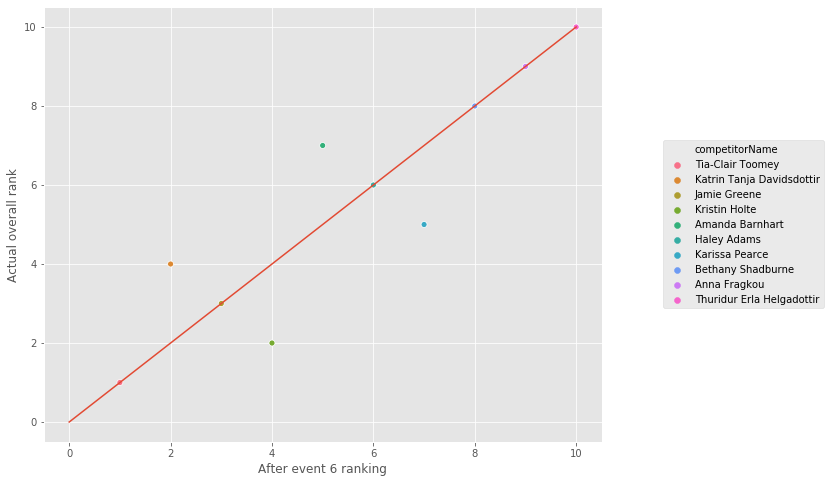

              competitorName  overallRank  afterEventSixRank
1  Katrin Tanja Davidsdottir            4                  2
3              Kristin Holte            2                  4
4            Amanda Barnhart            7                  5
6             Karissa Pearce            5                  7


In [711]:
## summing competitor points after 6 events and comparing to final rank
totalPointsAfterSixEventsFemales = df_cfgFemalesEvents[df_cfgFemalesEvents['event'] > 6]
# filtering out athletes that have been cut
totalPointsAfterSixEventsFemales = totalPointsAfterSixEventsFemales[totalPointsAfterSixEventsFemales['points'] > 0]
totalPointsAfterSixEventsFemales = totalPointsAfterSixEventsFemales[(['competitorId','points'])].groupby('competitorId').sum()
totalPointsAfterSixEventsFemales = totalPointsAfterSixEventsFemales.sort_values(by=['points'],ascending=False)
# initializing the afterEventSixRank
value = 0
totalPointsAfterSixEventsFemales['afterEventSixRank'] = value
# writting the afterEventSixRank into the dataframe
for i in range(0,len(totalPointsAfterSixEventsFemales)):
    totalPointsAfterSixEventsFemales['afterEventSixRank'].iloc[i] = 1 + i 
merged = pd.merge(totalPointsAfterSixEventsFemales, df_cfgFemales, on='competitorId', how='inner')
# plotting the results on a scatterplot, those that fall of the straight line are exceptions
f, ax = plt.subplots(figsize=(10,8))
g = sns.scatterplot(x='afterEventSixRank',y='overallRank',data=merged,hue='competitorName',ax=ax)
g.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)
# create a straight line and plot it
x = np.arange(0,11,1)
y = x
plt.plot(x, y, label='y=x')
#
plt.ylabel('Actual overall rank')
plt.xlabel('After event 6 ranking')
# saving the image
plt.savefig('overallrankVsFinal6Females.png', bbox_inches='tight')
# showing the image
plt.show()
# showing those that fall of the line
print(merged[(merged['afterEventSixRank']) != (merged['overallRank'])][(['competitorName','overallRank','afterEventSixRank'])])

## The end

**at least for now**